# Finding Counterexamples

This notebook contains the code used to search for counterexamples on each of the 456 tournament isomorphism classes of size 7.

In [1]:
%pip install python-sat
%pip install pref_voting

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pysat.formula import IDPool
from pysat.solvers import Solver
import itertools
import functools
from pref_voting.weighted_majority_graphs import MarginGraph
from pref_voting.margin_based_methods import split_cycle, stable_voting, simple_stable_voting
import copy
import matplotlib.pyplot as plt

In [3]:
pool = IDPool()
n = 7

# "precedes" variable definitions
def lt(a, b, c, d):
    if a == b or c == d:
        raise ValueError(f'Edges may not be self-loops.')
    if a == c and b == d:
        raise ValueError('Edges must be distinct.')
    if (a > d) or (a == d and b > c):
        return lt(d, c, b, a)
    return pool.id(f'{a}{b}{c}{d}')

# "SSV" variable definitions
def SSV(V, x):
    return pool.id(f"{x}win{''.join(str(v) for v in V)}")

# all undirected edges between a collection of nodes 
def edges(V=range(n)):
    return itertools.permutations(V, 2)

# true if node is reachable from sink with only edges with weight greater than source->sink
def reachable(source, sink, node):
    return pool.id('r:%s,%s,%s' % (source,sink,node))

# define reachable wrt edge given by source and sink
def reachability(s, source, sink):
    for (u, v) in edges():
        if (u, v) != (source, sink):
            s.add_clause([-reachable(source,sink,u), -lt(source, sink, u, v), reachable(source, sink, v)])
    s.add_clause([reachable(source, sink, sink)])

# define scwin(i)
def define_winner(s, i):
    for m in range(n):
        if m != i:
            reachability(m, i)
    # scwin(i) <- [reachable(m,i,m)] for all m != i
    s.add_clause([scwin(i)]+[-reachable(m,i,m) for m in range(n) if i!=m])

def ordering(s):
    added = set()
    for ((a, b), (c, d), (e, f)) in itertools.permutations(edges(), 3):
        first = lt(a, b, c, d)
        second = lt(c, d, e, f)
        if (first, second) not in added:
            added.add((first, second))
            s.add_clause([-first, -second, lt(a, b, e, f)])
    for ((a, b), (c, d)) in itertools.permutations(edges(), 2):
        s.add_clause([lt(a, b, c, d), lt(b, a, d, c)])
        s.add_clause([-lt(a, b, c, d), -lt(b, a, d, c)])


def removed(V, x):
    return tuple(v for v in V if v != x)


def SSV_conditions(s):
    for V in itertools.chain.from_iterable(itertools.combinations(range(n), r) for r in range(1, n+1)):
        s.add_clause([SSV(V, x) for x in V])

        for (x, y) in edges(V):
            s.add_clause([-SSV(V, x), -SSV(V, y)])
        
        for (a, b) in edges(V):
            clause = [-SSV(removed(V, b), a), SSV(V, a)]
            for (c, d) in edges(V):
                if c != a or d != b:
                    # tseitin iff -SSV((removed(V, d), c)) \/ lt(c, d, a, b)
                    tseitin = pool.id(f"t{a}{b}{c}{d}in{''.join(str(x) for x in V)}")
                    s.add_clause([-SSV(removed(V, d), c), lt(c, d, a, b), -tseitin])
                    s.add_clause([SSV(removed(V, d), c), tseitin])
                    s.add_clause([-lt(c, d, a, b), tseitin])
                    clause.append(-tseitin)
            s.add_clause(clause)

def check_model(model):
    def compare(x, y):
        (a, b) = x
        (c, d) = y
        return 1 if lt(a, b, c, d) in model else -1 # descending
    edge_list = sorted(edges(), key=functools.cmp_to_key(compare))
    max_weight = (n * (n - 1) // 2)
    return MarginGraph(list(range(n)), 
                       [(edge_list[i][0], edge_list[i][1], max_weight - i) for i in range(len(edge_list) // 2)])

def get_tournament(bitstring):
    graph = []
    b = 0
    for i in range(n):
        for j in range(i+1,n):
            if int(bitstring[b]): graph.append((i,j)) # (i,j) is in graph
            else: graph.append((j,i)) # (j,i) in graph
            b+=1
    return graph
    
def specify_tournament(s, tournament):
    for i,j in tournament:
        s.add_clause([lt(j,i,i,j)])
    



In [4]:
# fix for display() not allowing us to save the graph img
basic_show = plt.show
def save_plot(bitstring):
    # saves the plot before clearing it
    def save_show(*args, **kwargs):
        plt.savefig(f"witnesses/{bitstring}.jpg")

        basic_show(*args, **kwargs)

    plt.show = save_show

In [5]:
def call_solver_on_tournament(bitstring):
    print(bitstring)
    tournament = get_tournament(bitstring)
    print(tournament)

    count = 0
    for i,j in tournament: # 21 cases should not be too bad
        count+=1
        print(f"checking critical edge {count}: ({i}, {j})", end="\r")

        s = Solver(use_timer=True) 
        ordering(s)
        SSV_conditions(s)
        reachability(s, i, j)

        specify_tournament(s, tournament)  
        # counterexample when [j ssv] but [i not reachable from j with edges > margin(i,j)]
        s.add_clause([-reachable(i,j,i)]) # j is not sc winner
        s.add_clause([SSV(range(n), j)])# j is ssv winner

        if s.solve():
            result = check_model(s.get_model())
            save_plot(bitstring) # call before display() so graph gets saved
            result.display()
            with open(f"witnesses/{bitstring}.txt", 'w') as file:
                file.write(f"Split Cycle Winners: {split_cycle(result)}\n")
                file.write(f"Stable Voting Winner: {stable_voting(result)}\n")
                file.write(f"Simple Stable Voting Winner: {simple_stable_voting(result)}\n")

            print(f"Time: {s.time()}")
            print(f"Split Cycle Winners: {split_cycle(result)}")
            print(f"Stable Voting Winner: {stable_voting(result)}")
            print(f"Simple Stable Voting Winner: {simple_stable_voting(result)}")

            
            return True
        s.delete()

    # didn't find anything
    print(f"No counterexamples of size {n} for bitstring {bitstring}")
    return False


010100010010110101101
[(1, 0), (0, 2), (3, 0), (0, 4), (5, 0), (6, 0), (2, 1), (1, 3), (4, 1), (5, 1), (1, 6), (3, 2), (2, 4), (2, 5), (6, 2), (3, 4), (5, 3), (3, 6), (4, 5), (6, 4), (5, 6)]
checking critical edge 2: (0, 2)

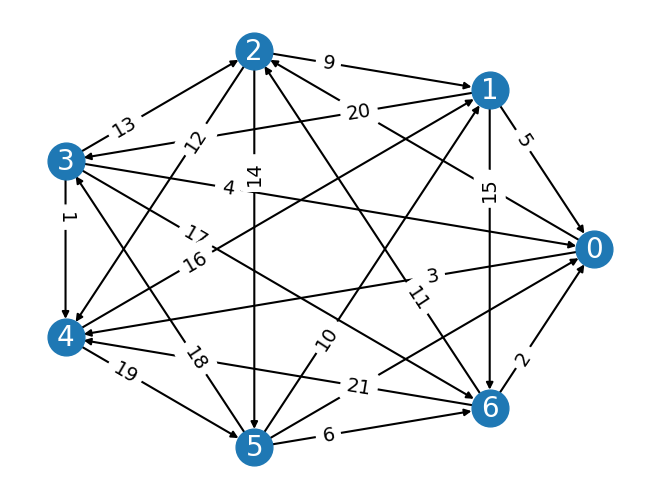

Time: 43.55360699999999
Split Cycle Winners: [0, 1, 6]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [2]


True

In [6]:
# This example tournament has a model.
call_solver_on_tournament("010100010010110101101") 

000000000000000000000

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 000000000000000000000

1
000000000000000000101

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 000000000000000000101

2
000000000000000100010

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 000000000000000100010

3
000000000000000100100

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (6, 5)]
No counterexamples of size 7

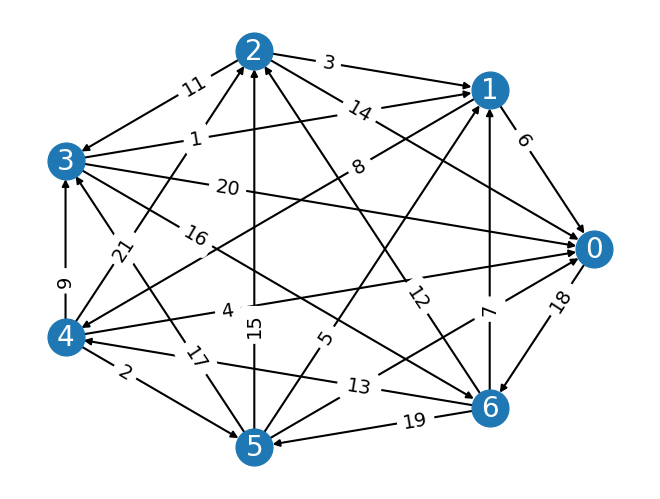

Time: 14.772909000000027
Split Cycle Winners: [1, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [4]
59
000001100000010000000

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (0, 6), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (2, 5), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 000001100000010000000

60
000001100001000000000

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (0, 6), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 000001100001000000000

61
000001100001000100100

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (0, 6), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 000001100001000100100

62
000001100001001100100

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (0, 6), (1, 2), (3, 1), (4, 1), (5, 1)

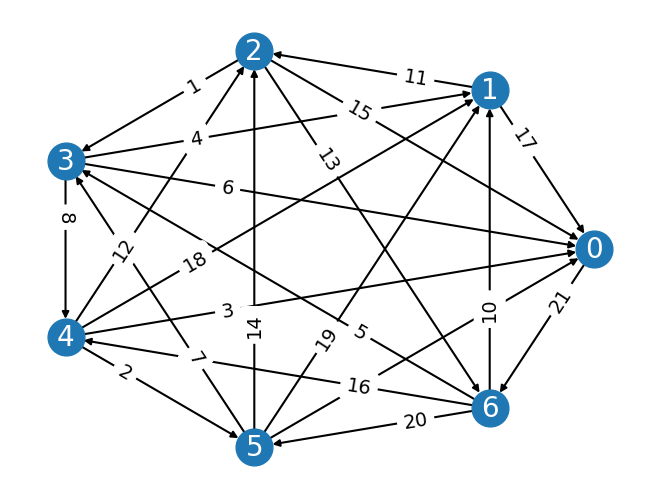

Time: 7.58547099999987
Split Cycle Winners: [2, 3]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [4]
63
000001100001010100000

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (0, 6), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 000001100001010100000

64
000001100001010100101

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (0, 6), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 000001100001010100101

65
000001100001100100100

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (0, 6), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 000001100001100100100

66
000001110001010110000

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (0, 6), (1, 2), (1, 3), (4, 1), (5, 1), 

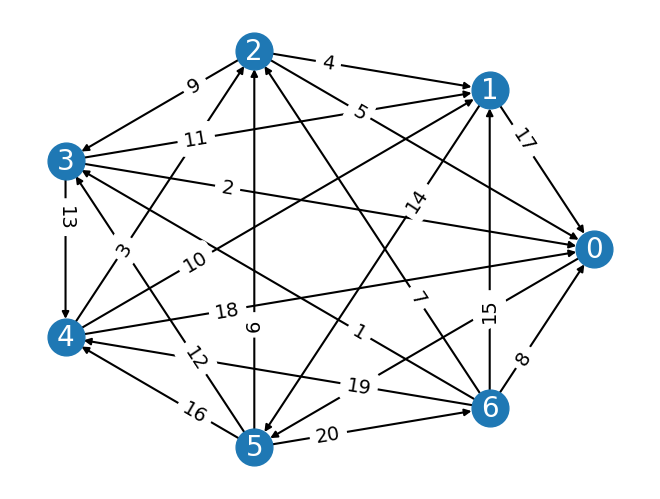

Time: 4.731624000000011
Split Cycle Winners: [1, 2]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [3]
71
000010001001000001101

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (2, 1), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (4, 3), (5, 3), (3, 6), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 000010001001000001101

72
000010001001000100010

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (2, 1), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 000010001001000100010

73
000010001001000100111

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (2, 1), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (4, 6), (5, 6)]
checking critical edge 5: (0, 5)

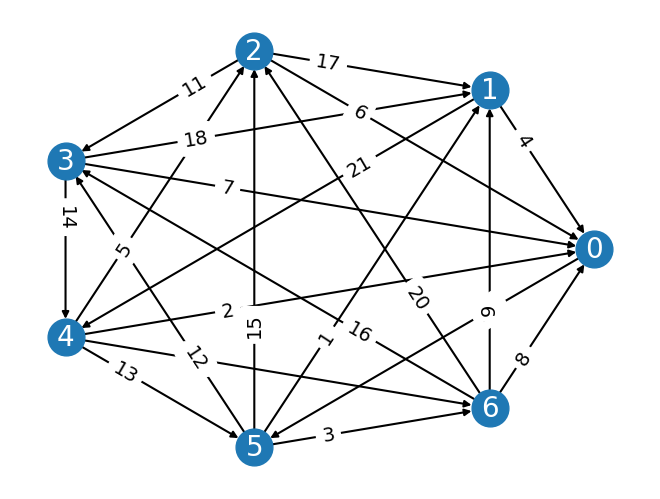

Time: 15.771792000000005
Split Cycle Winners: [0, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [5]
74
000010100000001000000

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (2, 6), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 000010100000001000000

75
000010100000010000001

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (2, 5), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (5, 6)]
checking critical edge 16: (4, 3)

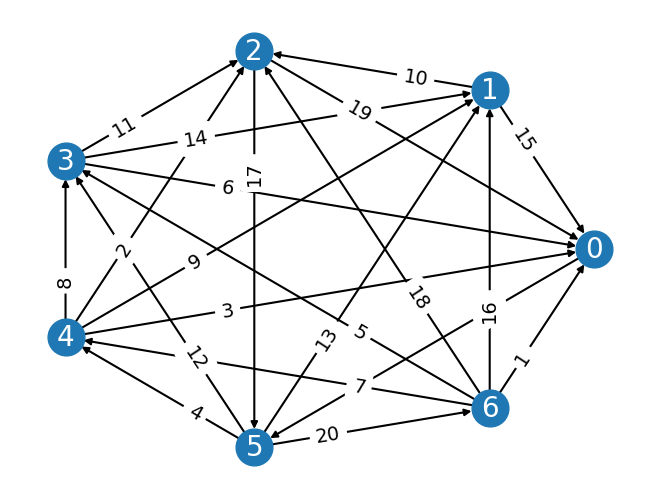

Time: 4.608759000000191
Split Cycle Winners: [2, 4]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [3]
76
000010100000100000000

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 000010100000100000000

77
000010100000100000001

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 000010100000100000001

78
000010100000100000101

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 000010100000100000101

79
000010100001000010001

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1),

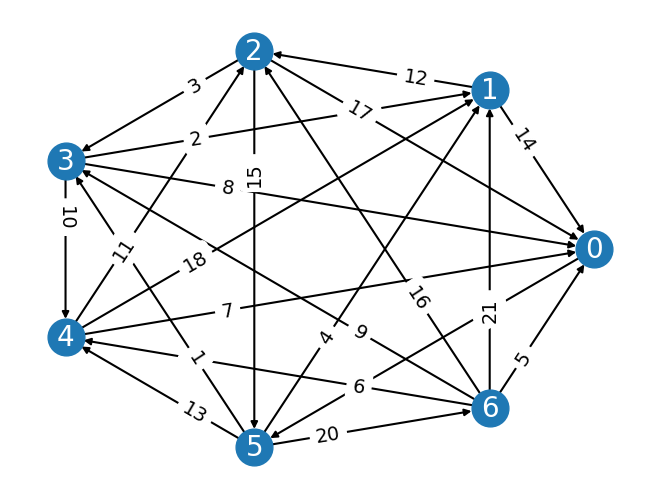

Time: 9.708599999999933
Split Cycle Winners: [2, 3]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [4]
83
000010100001100100010

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 000010100001100100010

84
000010100001100100101

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 7: (1, 2)

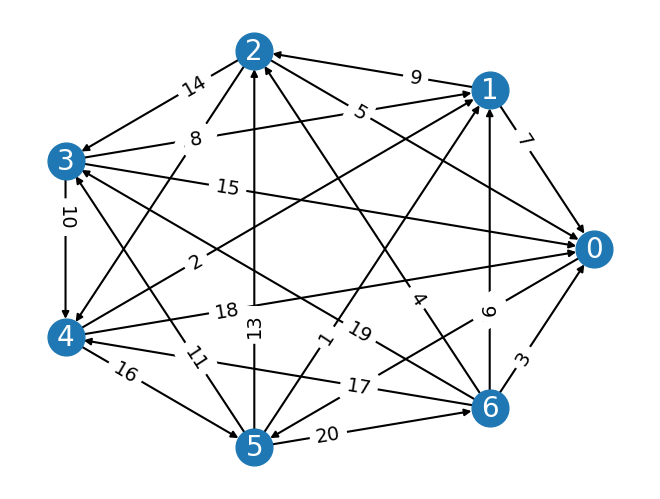

Time: 5.425880999999663
Split Cycle Winners: [1, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [2]
85
000010100001100100111

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (4, 6), (5, 6)]
No counterexamples of size 7 for bitstring 000010100001100100111

86
000010100101100100011

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (5, 6)]
checking critical edge 5: (0, 5)

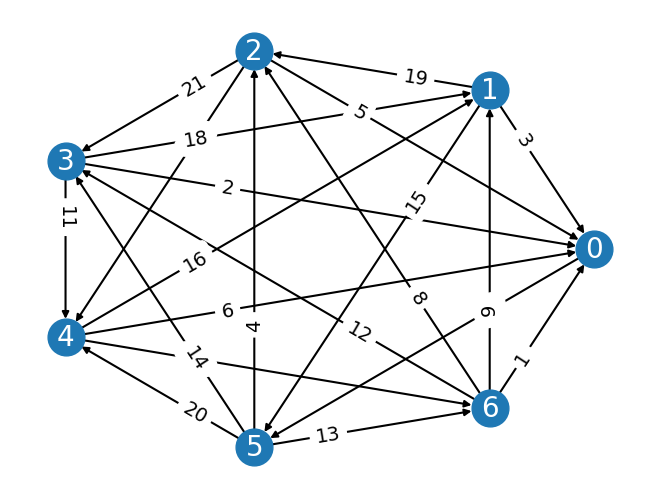

Time: 23.22499400000015
Split Cycle Winners: [0, 1]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [5]
87
000010101001100001010

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (4, 3), (5, 3), (3, 6), (5, 4), (4, 6), (6, 5)]
checking critical edge 5: (0, 5)

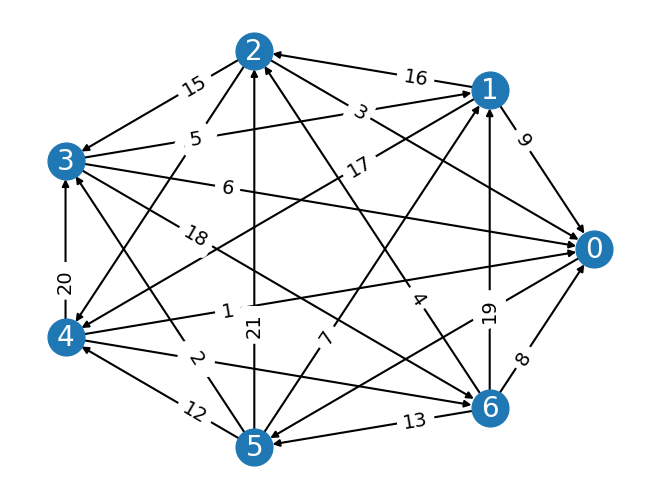

Time: 18.381677999999738
Split Cycle Winners: [0, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [5]
88
000010101001100010101

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (4, 3), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 7: (1, 2)

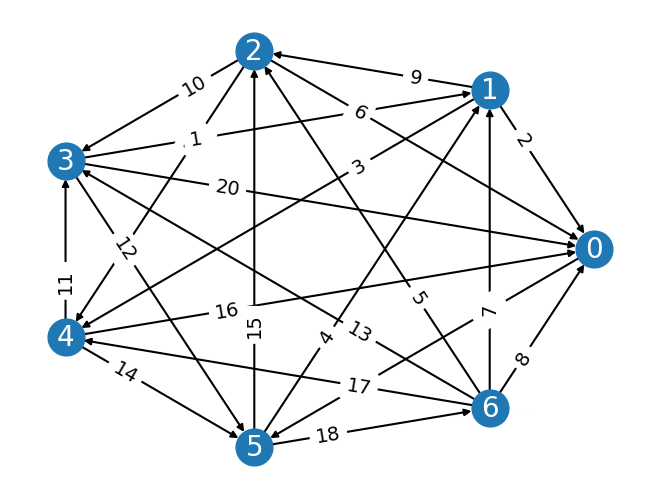

Time: 7.596148000000085
Split Cycle Winners: [1, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [2]
89
000010101001100100111

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (4, 6), (5, 6)]
checking critical edge 5: (0, 5)

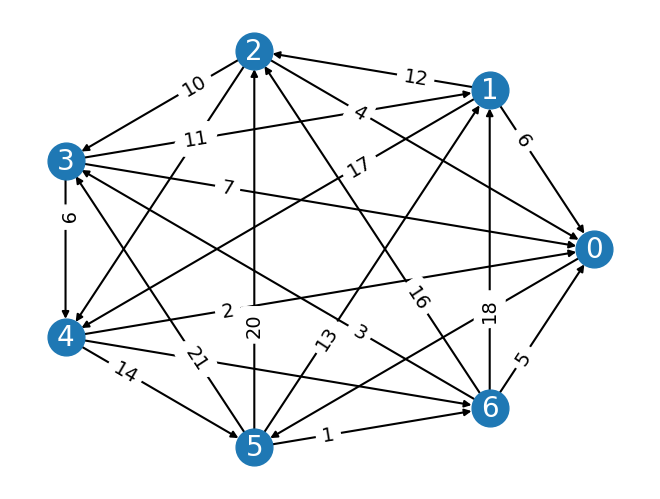

Time: 29.774461999999858
Split Cycle Winners: [0, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [5]
90
000010110001100110011

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (5, 4), (4, 6), (5, 6)]
checking critical edge 5: (0, 5)

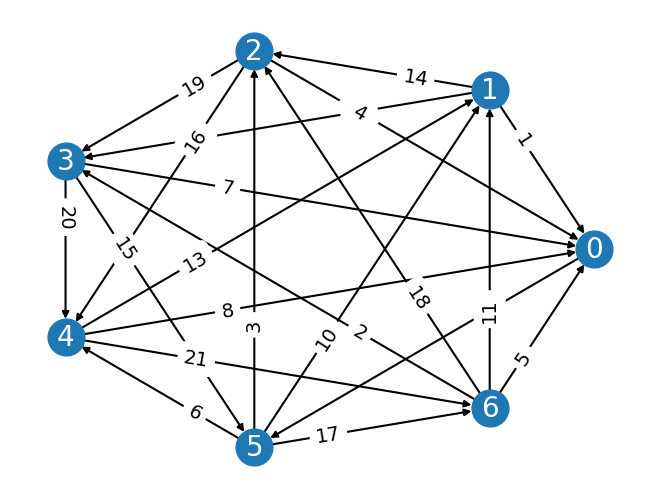

Time: 14.522609000000102
Split Cycle Winners: [0, 1]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [5]
91
000011000101000100001

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (0, 6), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (6, 4), (5, 6)]
checking critical edge 10: (1, 5)

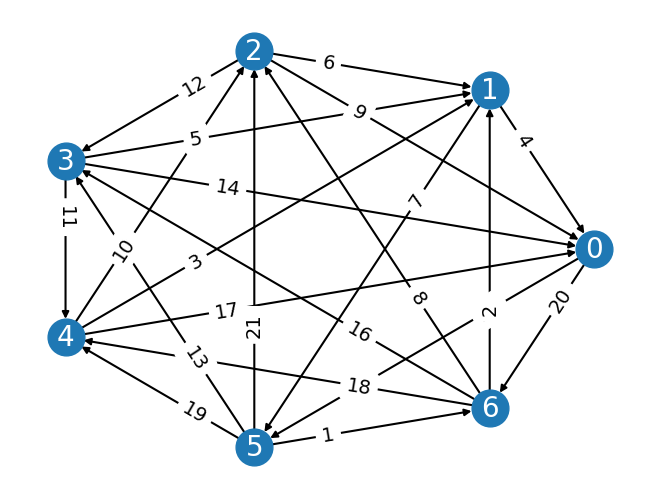

Time: 8.414952000000085
Split Cycle Winners: [0, 1]
Stable Voting Winner: [0]
Simple Stable Voting Winner: [5]
92
000011100001000100101

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (0, 6), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 19: (4, 5)

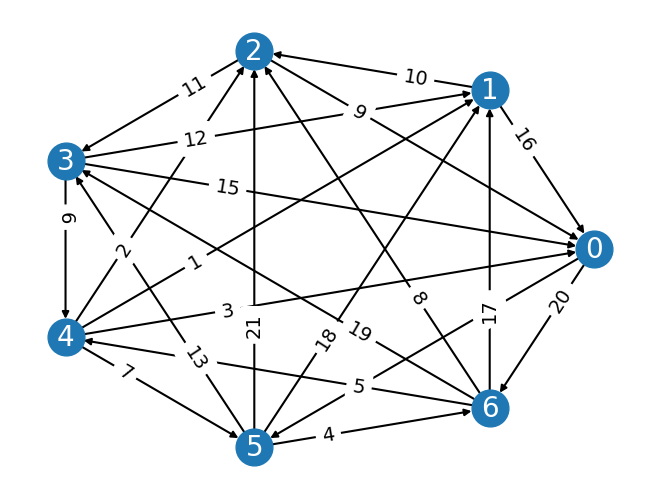

Time: 5.903842000000168
Split Cycle Winners: [0, 4]
Stable Voting Winner: [0]
Simple Stable Voting Winner: [5]
93
000011100001010100001

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (0, 6), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (6, 4), (5, 6)]
checking critical edge 14: (2, 5)

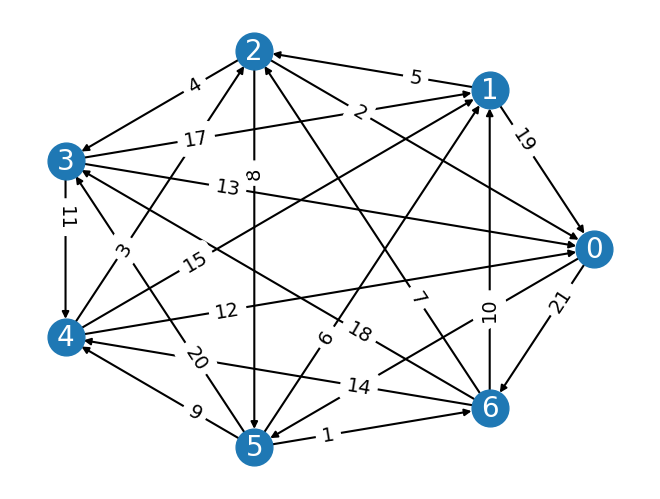

Time: 16.89328599999999
Split Cycle Winners: [2, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [5]
94
000011100001100100010

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (0, 6), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
checking critical edge 7: (1, 2)

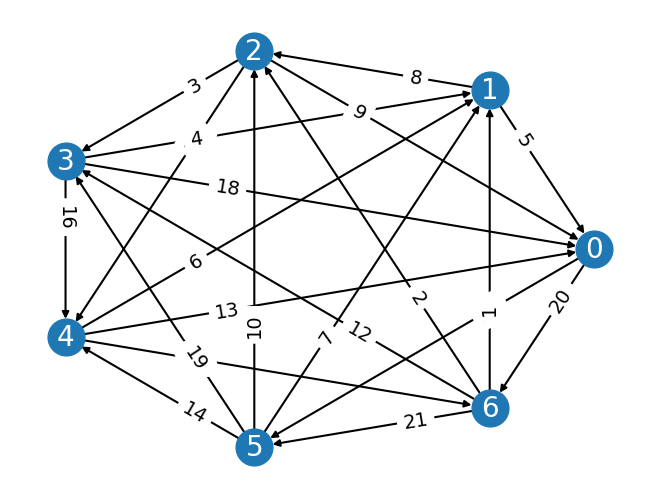

Time: 31.0873059999999
Split Cycle Winners: [0, 1]
Stable Voting Winner: [0]
Simple Stable Voting Winner: [2]
95
000011101001100010101

[(1, 0), (2, 0), (3, 0), (4, 0), (0, 5), (0, 6), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (4, 3), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 6: (0, 6)

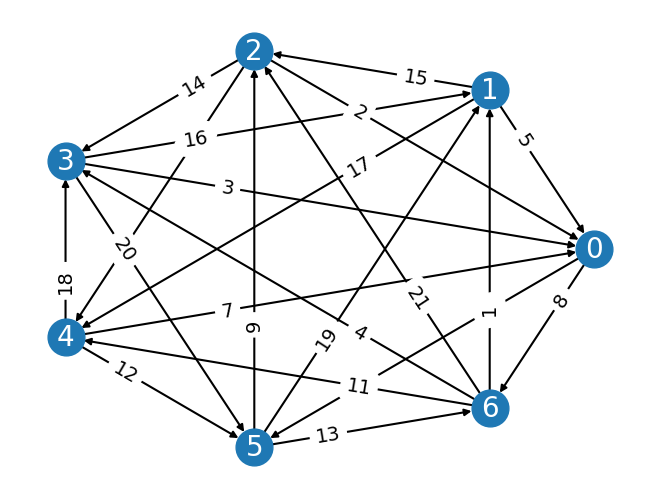

Time: 12.660534999999982
Split Cycle Winners: [0, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [6]
96
000100000001000110111

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (4, 6), (5, 6)]
No counterexamples of size 7 for bitstring 000100000001000110111

97
000100000101000100010

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 000100000101000100010

98
000100001000010000111

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (5, 1), (6, 1), (3, 2), (4, 2), (2, 5), (6, 2), (4, 3), (5, 3), (6, 3), (4, 5), (4, 6), (5, 6)]
checking critical edge 14: (2, 5)

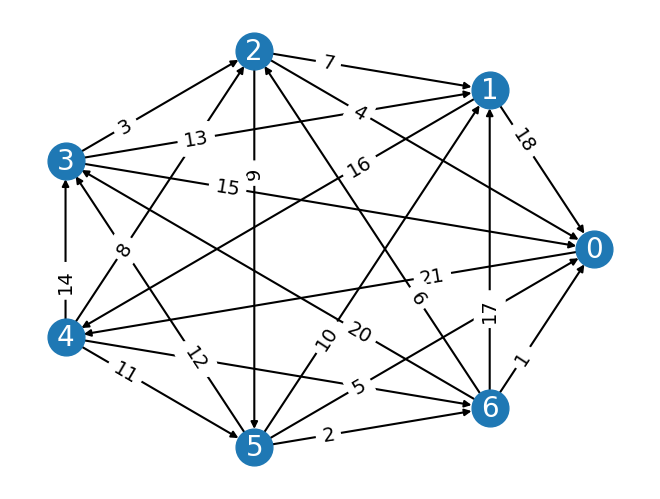

Time: 16.688567999999577
Split Cycle Winners: [1, 2]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [5]
99
000100001001000010010

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (4, 3), (3, 5), (6, 3), (5, 4), (4, 6), (6, 5)]
checking critical edge 12: (2, 3)

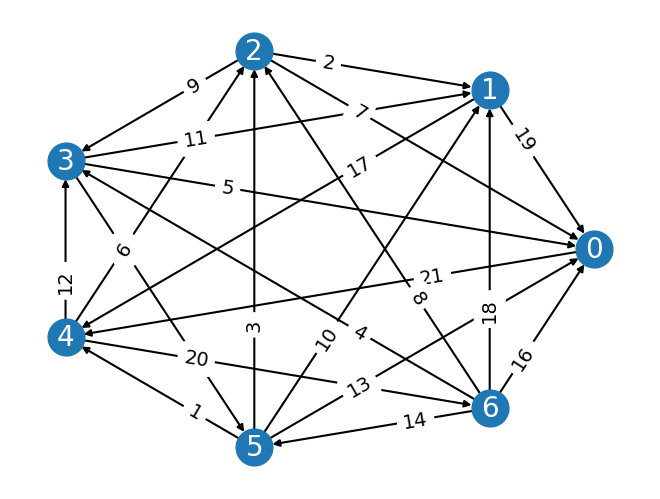

Time: 3.723949000000175
Split Cycle Winners: [1, 2]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [3]
100
000100001001000100110

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (4, 6), (6, 5)]
checking critical edge 14: (5, 2)

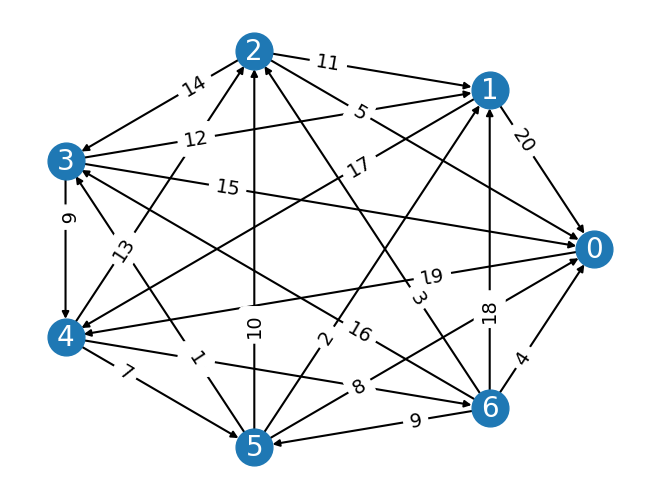

Time: 3.343112999999903
Split Cycle Winners: [1, 5]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [2]
101
000100010000010100010

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (2, 1), (1, 3), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 000100010000010100010

102
000100010001000110010

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (2, 1), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (5, 4), (4, 6), (6, 5)]
checking critical edge 14: (5, 2)

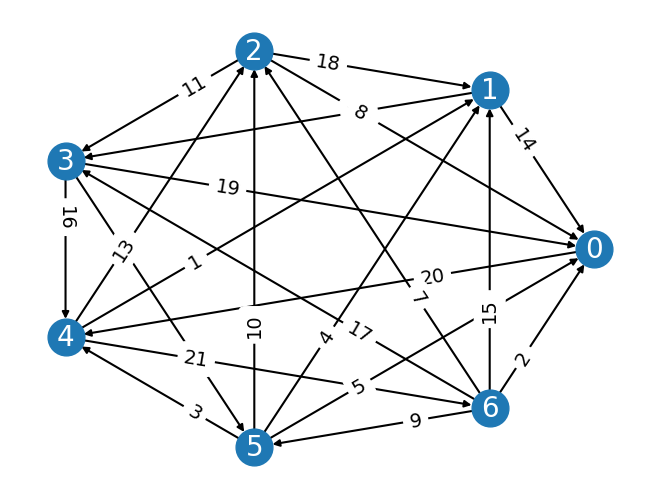

Time: 1.6731220000001485
Split Cycle Winners: [3, 5]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [2]
103
000100100000010000101

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (2, 5), (6, 2), (4, 3), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 000100100000010000101

104
000100100000011000101

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (2, 5), (2, 6), (4, 3), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 000100100000011000101

105
000100100000110000111

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (2, 4), (2, 5), (6, 2), (4, 3), (5, 3), (6, 3), (4, 5), (4, 6), (5, 6)]
checking critical edge 4: (0, 4)

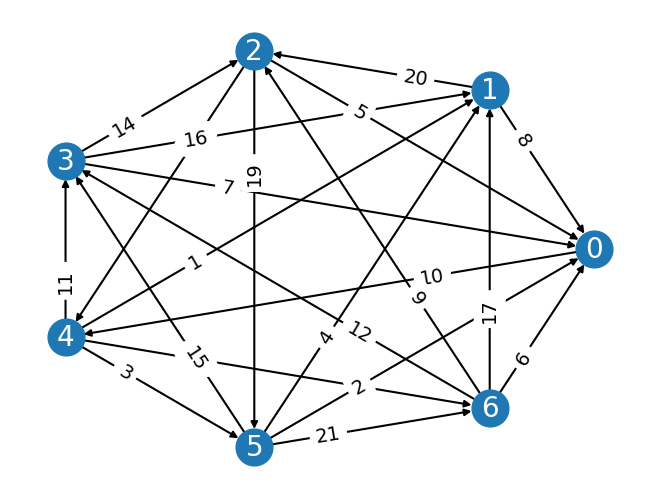

Time: 11.5213219999996
Split Cycle Winners: [0, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [4]
106
000100100001000000000

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 000100100001000000000

107
000100100001000000100

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (4, 5), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 000100100001000000100

108
000100100001000000101

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 000100100001000000101

109
000100100001000001100

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 

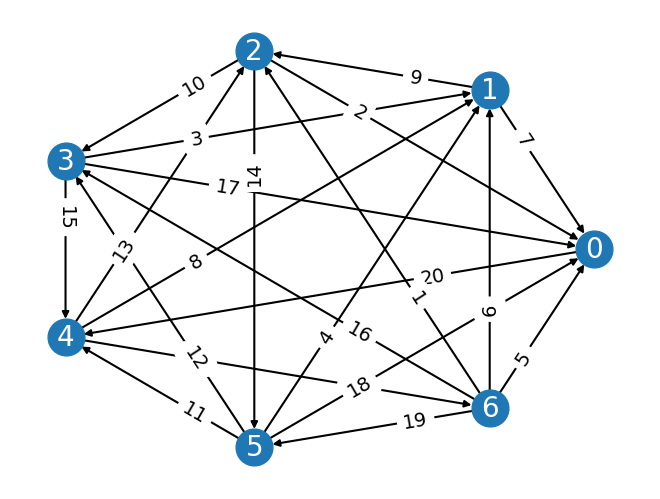

Time: 4.0984269999999015
Split Cycle Winners: [1, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [2]
112
000100100001010100111

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (4, 6), (5, 6)]
No counterexamples of size 7 for bitstring 000100100001010100111

113
000100100001100100110

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 000100100001100100110

114
000100110001010110101

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 000100110001010110101

115
000101100001000100110

[(1, 0), (2, 0), (3, 0), (0, 4), (5, 0), (0, 6), (1, 2), (3, 1), (4, 1), (5

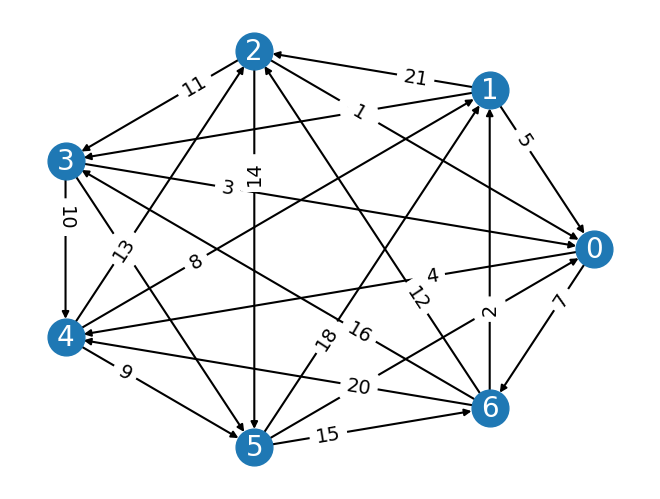

Time: 43.45947799999976
Split Cycle Winners: [0, 5]
Stable Voting Winner: [5]
Simple Stable Voting Winner: [6]
117
000110100000001000000

[(1, 0), (2, 0), (3, 0), (0, 4), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (2, 6), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 000110100000001000000

118
000110101001010010011

[(1, 0), (2, 0), (3, 0), (0, 4), (0, 5), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (4, 3), (3, 5), (6, 3), (5, 4), (4, 6), (5, 6)]
checking critical edge 7: (1, 2)

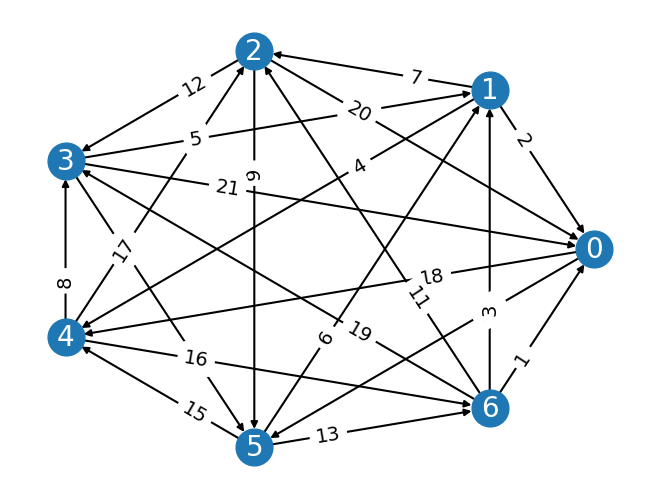

Time: 24.41308200000003
Split Cycle Winners: [1, 5, 6]
Stable Voting Winner: [5]
Simple Stable Voting Winner: [2]
119
000110110001010110011

[(1, 0), (2, 0), (3, 0), (0, 4), (0, 5), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (3, 5), (6, 3), (5, 4), (4, 6), (5, 6)]
checking critical edge 2: (2, 0)

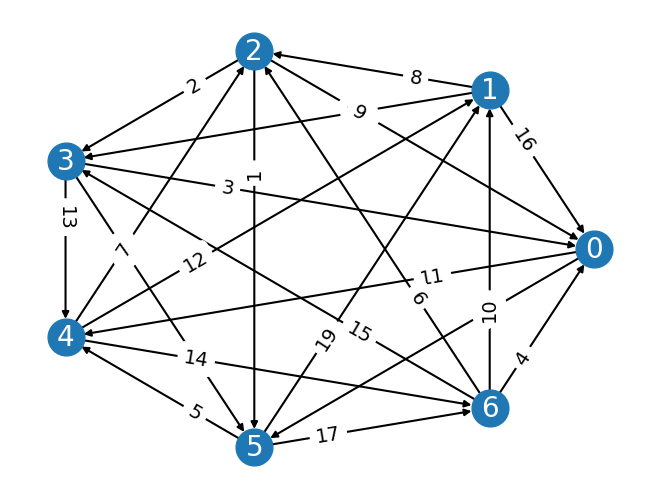

Time: 28.0088939999996
Split Cycle Winners: [1, 2, 4]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [0]
120
001000000000000110101

[(1, 0), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 001000000000000110101

121
001000001000000110111

[(1, 0), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (4, 6), (5, 6)]
No counterexamples of size 7 for bitstring 001000001000000110111

122
001000001000010001101

[(1, 0), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (5, 1), (6, 1), (3, 2), (4, 2), (2, 5), (6, 2), (4, 3), (5, 3), (3, 6), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 001000001000010001101

123
001000001000010100010

[(1, 0), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (

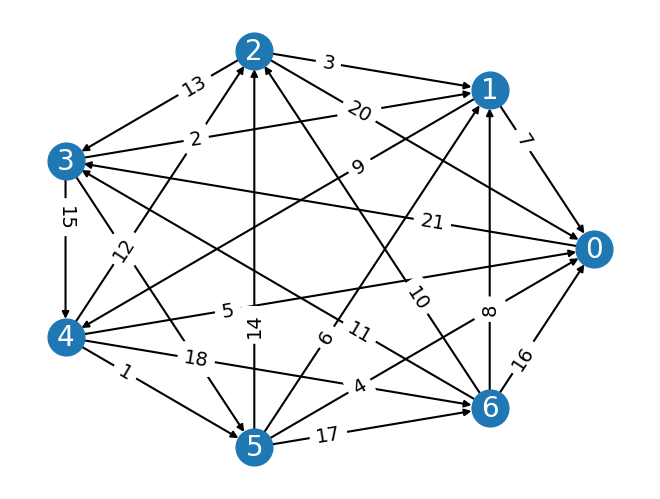

Time: 6.348526999999194
Split Cycle Winners: [1, 2]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [4]
128
001000010000100110010

[(1, 0), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (1, 3), (4, 1), (5, 1), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 001000010000100110010

129
001000100000001100000

[(1, 0), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (2, 6), (3, 4), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 001000100000001100000

130
001000100000001100100

[(1, 0), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (2, 6), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 001000100000001100100

131
001000100000001110101

[(1, 0), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5,

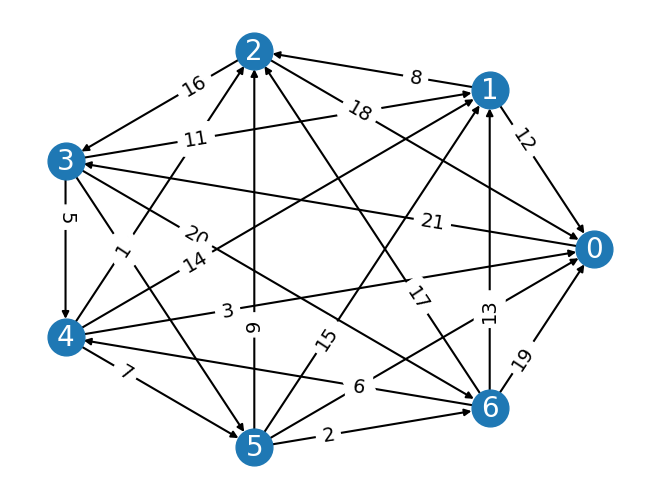

Time: 4.895450999999412
Split Cycle Winners: [2, 4]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [5]
150
001000100001001110101

[(1, 0), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (2, 6), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 20: (6, 4)

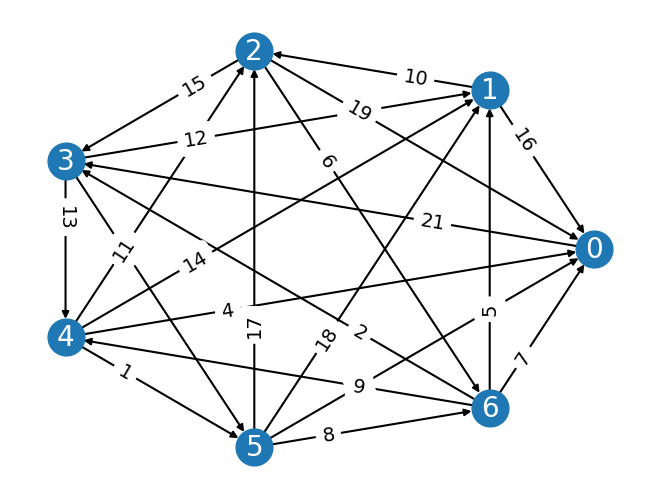

Time: 3.8059990000001562
Split Cycle Winners: [2, 6]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [4]
151
001000100001100110010

[(1, 0), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 001000100001100110010

152
001000100001100110111

[(1, 0), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (4, 6), (5, 6)]
No counterexamples of size 7 for bitstring 001000100001100110111

153
001010100000100100010

[(1, 0), (2, 0), (0, 3), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 001010100000100100010

154
001010100000101001000

[(1, 0), (2, 0), (0, 3), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5

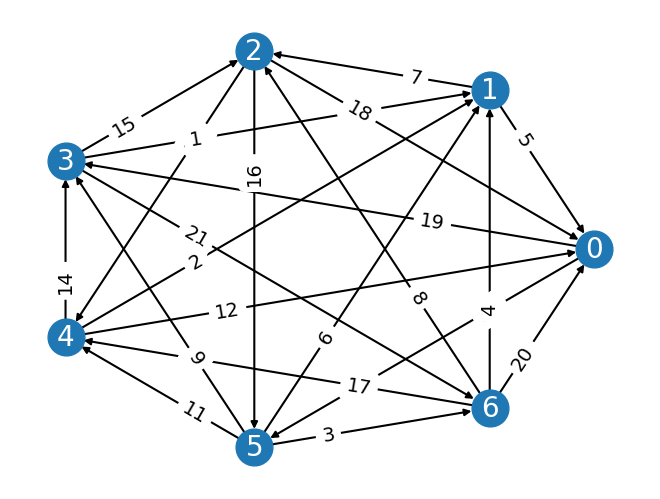

Time: 19.525093000000197
Split Cycle Winners: [1, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [2]
156
001010100000110100011

[(1, 0), (2, 0), (0, 3), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (2, 4), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (5, 6)]
checking critical edge 18: (6, 3)

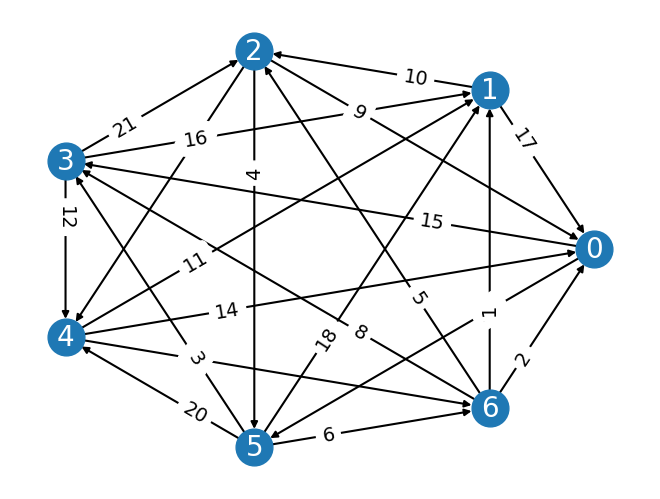

Time: 10.02518500000042
Split Cycle Winners: [0, 6]
Stable Voting Winner: [0]
Simple Stable Voting Winner: [3]
157
001010100001001101000

[(1, 0), (2, 0), (0, 3), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (2, 6), (3, 4), (5, 3), (3, 6), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 001010100001001101000

158
001010100001010101001

[(1, 0), (2, 0), (0, 3), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (3, 6), (5, 4), (6, 4), (5, 6)]
checking critical edge 1: (1, 0)

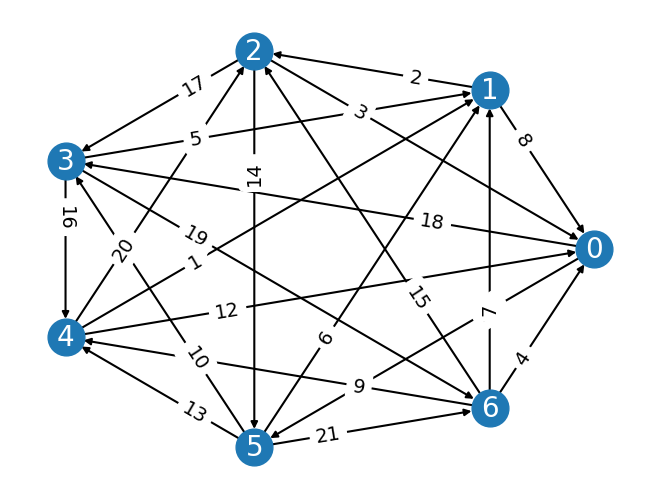

Time: 40.85673200000019
Split Cycle Winners: [1, 4, 5]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [0]
159
001010100001100011001

[(1, 0), (2, 0), (0, 3), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (4, 3), (3, 5), (3, 6), (5, 4), (6, 4), (5, 6)]
checking critical edge 7: (1, 2)

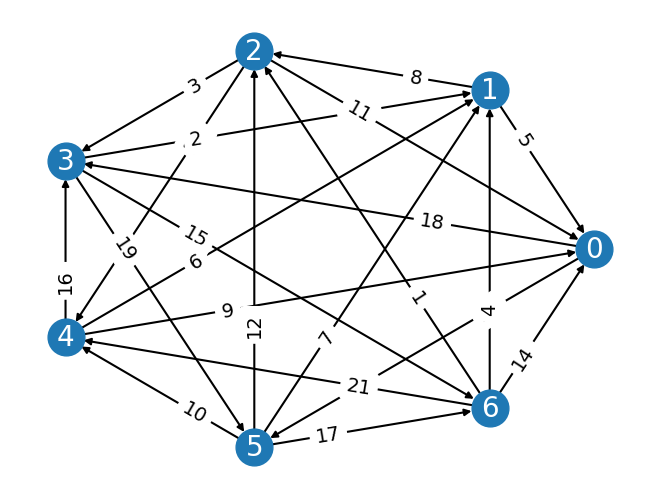

Time: 26.342876000000615
Split Cycle Winners: [0, 1]
Stable Voting Winner: [0]
Simple Stable Voting Winner: [2]
160
001010100001100101010

[(1, 0), (2, 0), (0, 3), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (3, 6), (5, 4), (4, 6), (6, 5)]
checking critical edge 21: (6, 5)

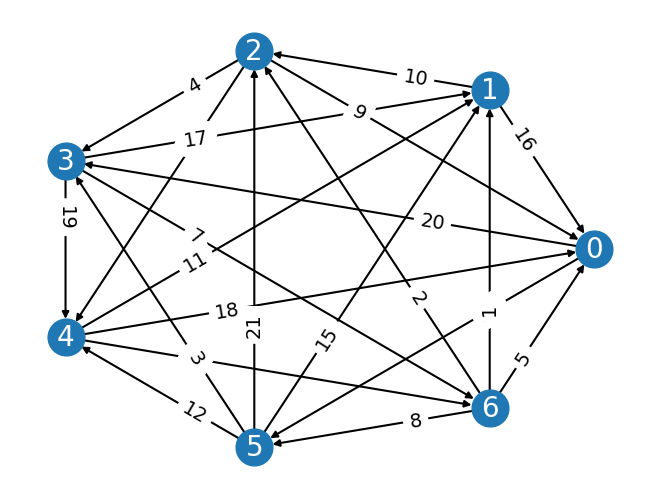

Time: 12.717040999999881
Split Cycle Winners: [0, 6]
Stable Voting Winner: [0]
Simple Stable Voting Winner: [5]
161
001010100001100101101

[(1, 0), (2, 0), (0, 3), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (3, 6), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 001010100001100101101

162
001010100001100110011

[(1, 0), (2, 0), (0, 3), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (5, 4), (4, 6), (5, 6)]
No counterexamples of size 7 for bitstring 001010100001100110011

163
001100000101000110101

[(1, 0), (2, 0), (0, 3), (0, 4), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 001100000101000110101

164
001100100000001010000

[(1, 0), (2, 0), (0, 3), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5

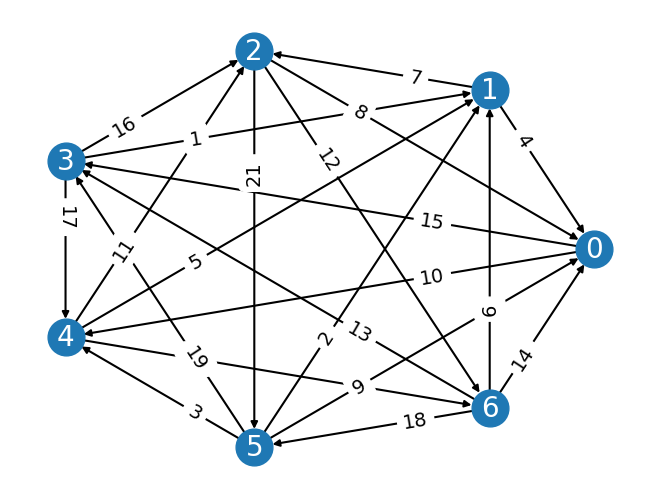

Time: 16.815107000000353
Split Cycle Winners: [0, 1, 4]
Stable Voting Winner: [0]
Simple Stable Voting Winner: [2]
166
001100100001010011001

[(1, 0), (2, 0), (0, 3), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (4, 3), (3, 5), (3, 6), (5, 4), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 001100100001010011001

167
001100100001010101010

[(1, 0), (2, 0), (0, 3), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (3, 6), (5, 4), (4, 6), (6, 5)]
checking critical edge 7: (1, 2)

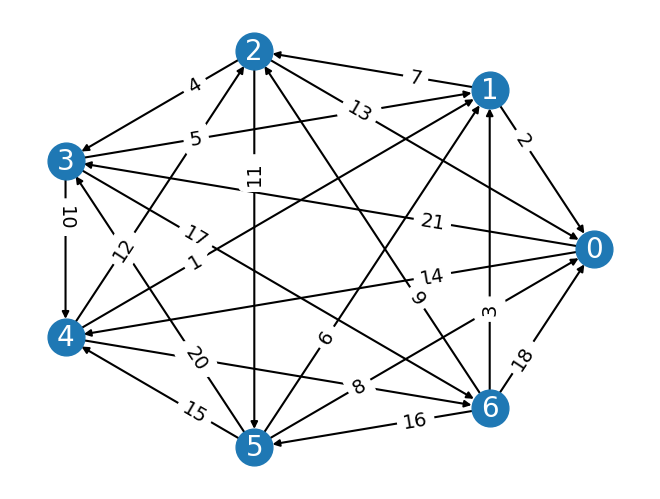

Time: 21.115993000001254
Split Cycle Winners: [1, 4, 5]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [2]
168
001100100001010101101

[(1, 0), (2, 0), (0, 3), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (3, 6), (4, 5), (6, 4), (5, 6)]
checking critical edge 21: (5, 6)

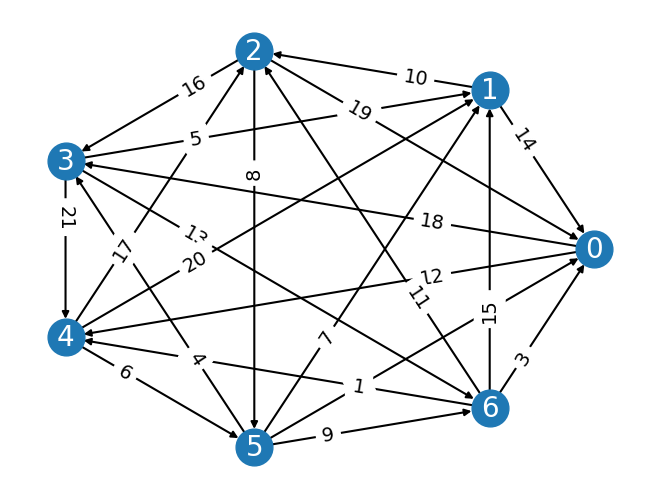

Time: 7.3056889999988925
Split Cycle Winners: [2, 5]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [6]
169
001100100001010110011

[(1, 0), (2, 0), (0, 3), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (3, 5), (6, 3), (5, 4), (4, 6), (5, 6)]
checking critical edge 7: (1, 2)

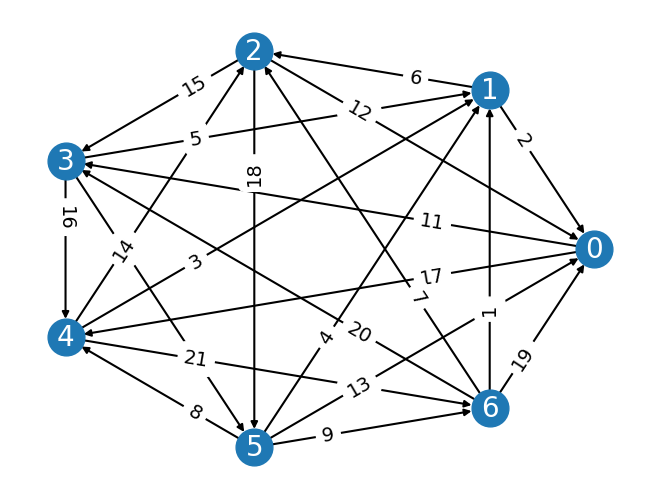

Time: 10.034216000000015
Split Cycle Winners: [1, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [2]
170
001100100001010110101

[(1, 0), (2, 0), (0, 3), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 001100100001010110101

171
001100100001100101110

[(1, 0), (2, 0), (0, 3), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (3, 6), (4, 5), (4, 6), (6, 5)]
checking critical edge 7: (1, 2)

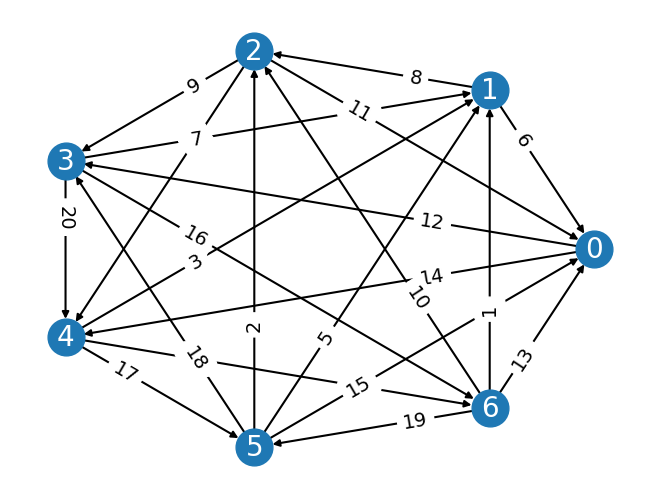

Time: 23.29223699999966
Split Cycle Winners: [1, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [2]
172
010000000000001100100

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (2, 6), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 010000000000001100100

173
010000000000010100101

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 010000000000010100101

174
010000000001000000101

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 010000000001000000101

175
010000000001000110101

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (5,

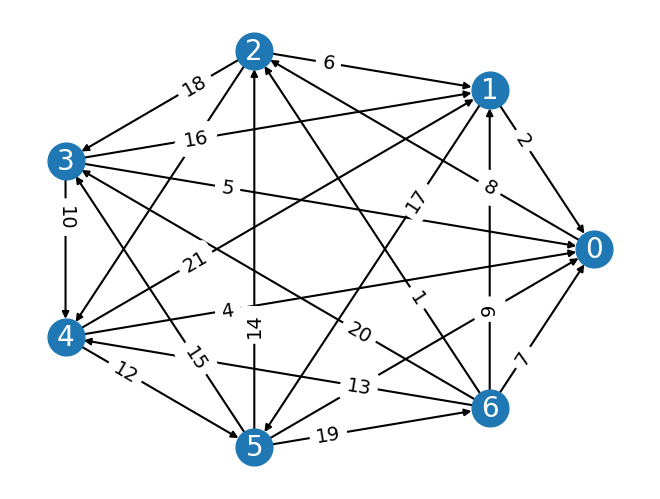

Time: 2.442259000001286
Split Cycle Winners: [0, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [2]
187
010000001000010000101

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (5, 1), (6, 1), (3, 2), (4, 2), (2, 5), (6, 2), (4, 3), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 010000001000010000101

188
010000001001001001100

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (2, 6), (4, 3), (5, 3), (3, 6), (4, 5), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 010000001001001001100

189
010000001001010001101

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (4, 3), (5, 3), (3, 6), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 010000001001010001101

190
010000001001010010001

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (5,

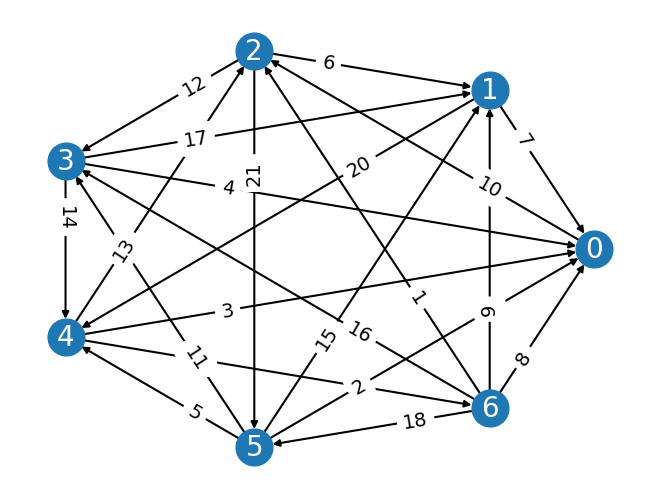

Time: 4.295673999999053
Split Cycle Winners: [0, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [2]
192
010000001001010100101

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 010000001001010100101

193
010000001001010100111

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (4, 6), (5, 6)]
No counterexamples of size 7 for bitstring 010000001001010100111

194
010000001001100100110

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 010000001001100100110

195
010000010000001100100

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (1, 3), (4, 1), (5,

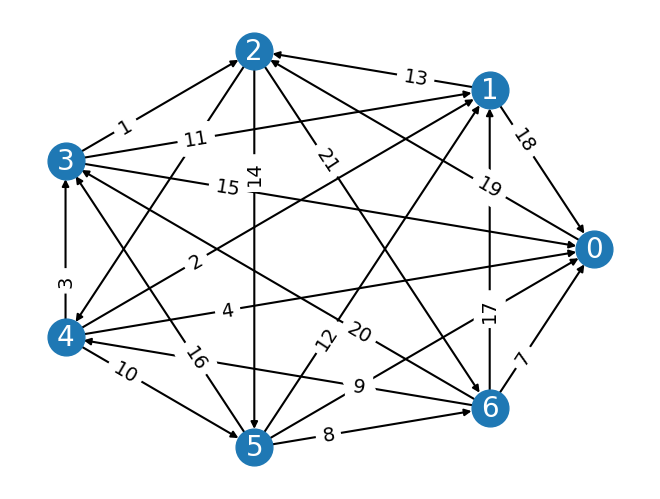

Time: 17.600988000000143
Split Cycle Winners: [1, 4]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [5]
205
010000100001001100100

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (2, 6), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 010000100001001100100

206
010000100001010010001

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (4, 3), (3, 5), (6, 3), (5, 4), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 010000100001010010001

207
010000100001010100101

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 010000100001010100101

208
010000100001011100101

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5

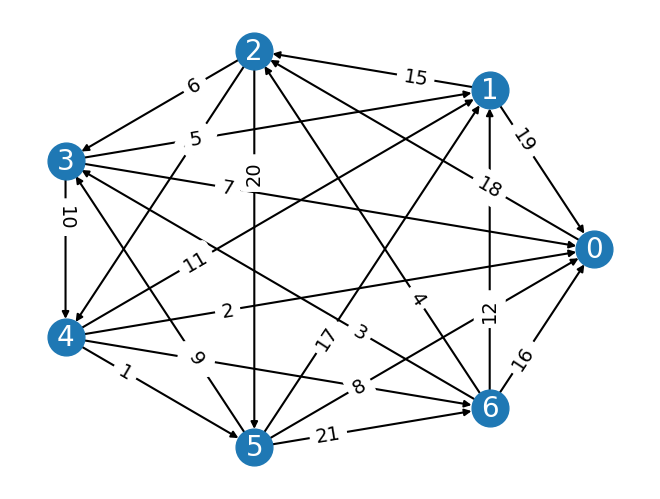

Time: 10.573410999999396
Split Cycle Winners: [1, 3]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [4]
212
010000110001110110101

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (2, 5), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 010000110001110110101

213
010001000101001100000

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (0, 6), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (2, 6), (3, 4), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
checking critical edge 10: (1, 5)

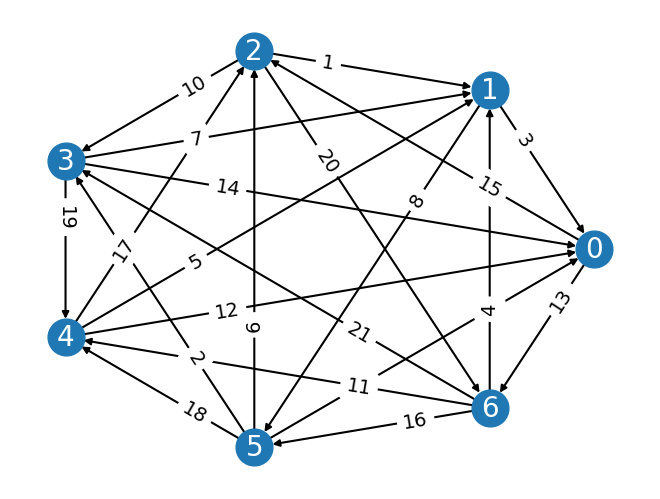

Time: 25.973087000000305
Split Cycle Winners: [0, 1]
Stable Voting Winner: [0]
Simple Stable Voting Winner: [5]
214
010001000101010100001

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (0, 6), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (6, 4), (5, 6)]
checking critical edge 10: (1, 5)

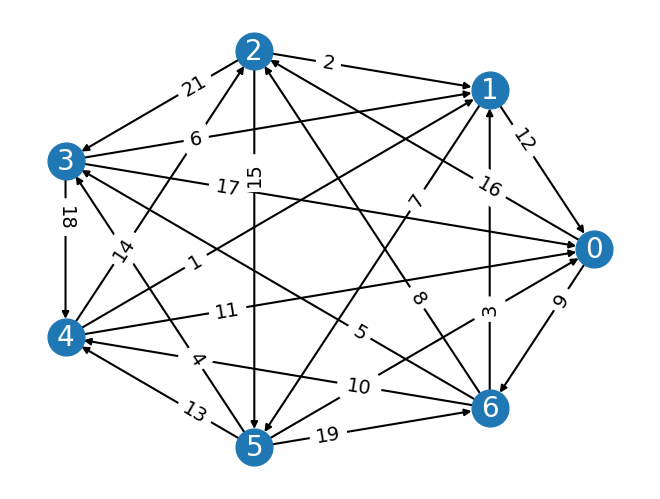

Time: 28.797200999999404
Split Cycle Winners: [1, 2]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [5]
215
010001000101100100010

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (0, 6), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
checking critical edge 10: (1, 5)

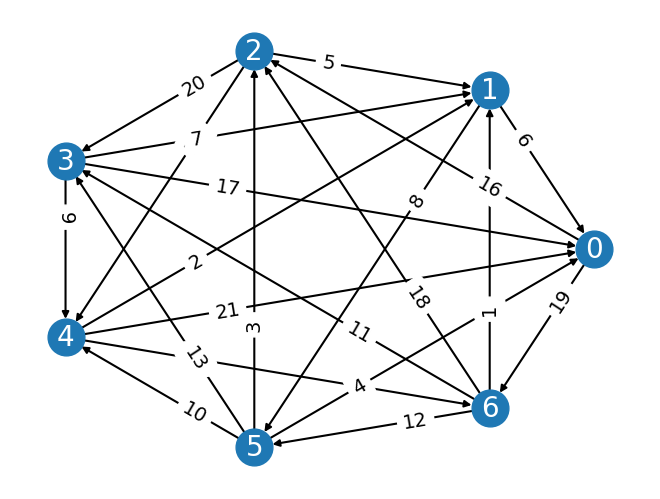

Time: 14.343620000001465
Split Cycle Winners: [1, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [5]
216
010001000101100100101

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (0, 6), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 8: (3, 1)

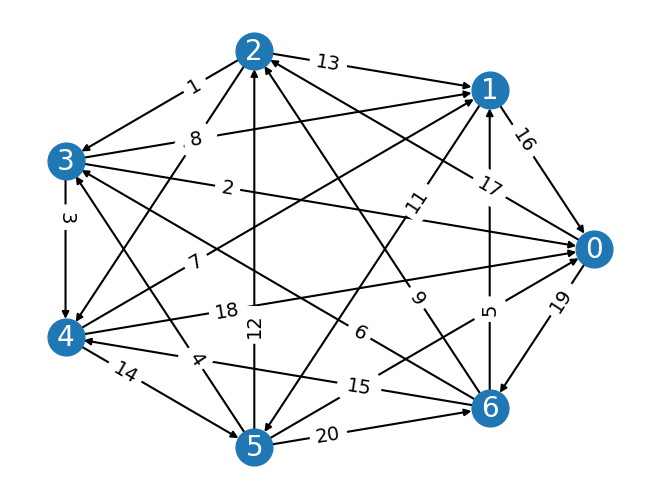

Time: 20.187230999999883
Split Cycle Winners: [2, 3, 5]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [1]
217
010001110001110110101

[(1, 0), (0, 2), (3, 0), (4, 0), (5, 0), (0, 6), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (2, 5), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 6: (0, 6)

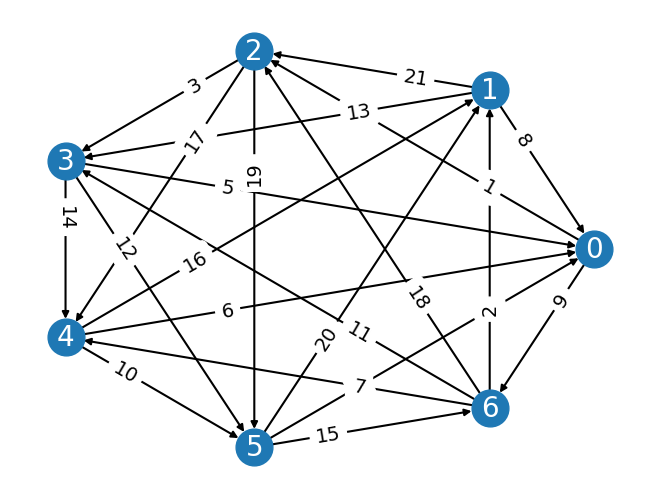

Time: 24.75646400000005
Split Cycle Winners: [0, 3, 5]
Stable Voting Winner: [5]
Simple Stable Voting Winner: [6]
218
010010000101001100001

[(1, 0), (0, 2), (3, 0), (4, 0), (0, 5), (6, 0), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (2, 6), (3, 4), (5, 3), (6, 3), (5, 4), (6, 4), (5, 6)]
checking critical edge 10: (1, 5)

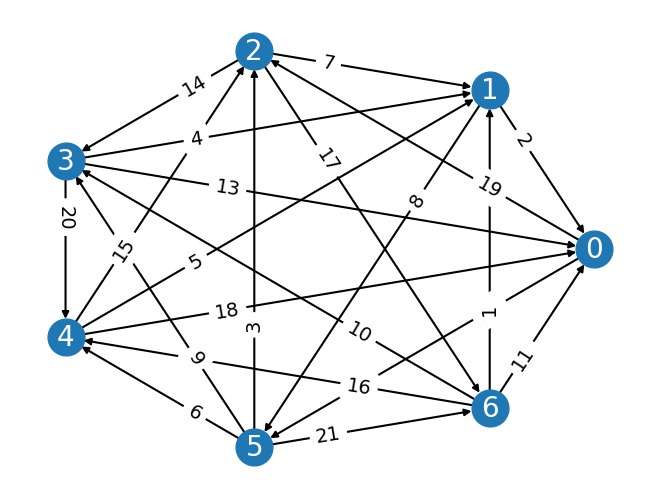

Time: 10.945212999999058
Split Cycle Winners: [1, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [5]
219
010010000101100100011

[(1, 0), (0, 2), (3, 0), (4, 0), (0, 5), (6, 0), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (5, 6)]
checking critical edge 10: (1, 5)

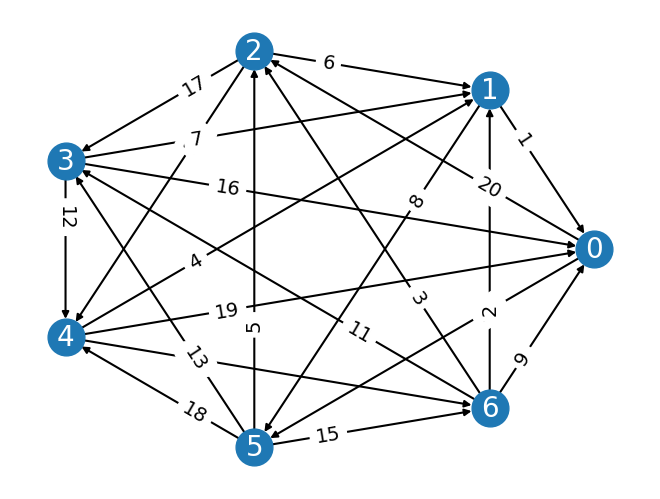

Time: 15.709656999999424
Split Cycle Winners: [0, 1]
Stable Voting Winner: [0]
Simple Stable Voting Winner: [5]
220
010010000101100100101

[(1, 0), (0, 2), (3, 0), (4, 0), (0, 5), (6, 0), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 2: (0, 2)

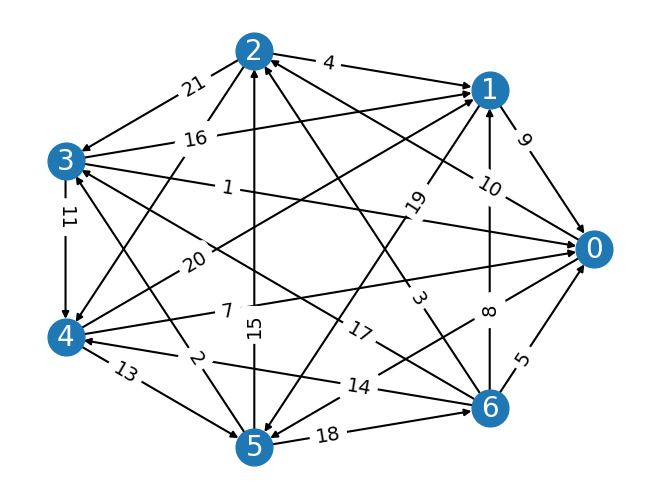

Time: 14.86733699999968
Split Cycle Winners: [0, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [2]
221
010010010000100010001

[(1, 0), (0, 2), (3, 0), (4, 0), (0, 5), (6, 0), (2, 1), (1, 3), (4, 1), (5, 1), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (4, 3), (3, 5), (6, 3), (5, 4), (6, 4), (5, 6)]
checking critical edge 13: (2, 4)

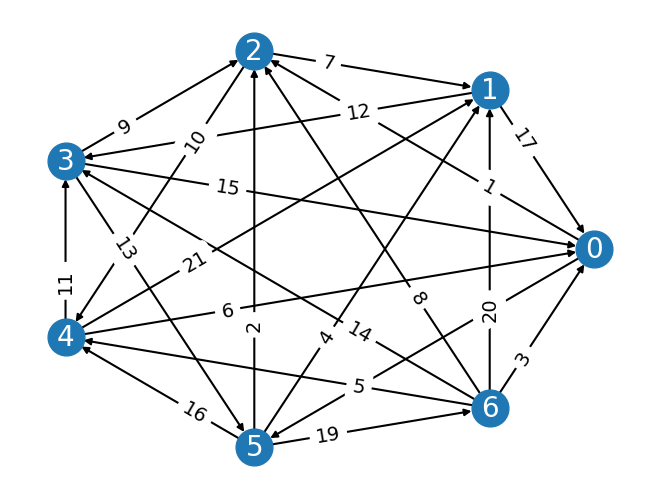

Time: 1.1038160000007338
Split Cycle Winners: [2, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [4]
222
010010010000110001001

[(1, 0), (0, 2), (3, 0), (4, 0), (0, 5), (6, 0), (2, 1), (1, 3), (4, 1), (5, 1), (6, 1), (3, 2), (2, 4), (2, 5), (6, 2), (4, 3), (5, 3), (3, 6), (5, 4), (6, 4), (5, 6)]
checking critical edge 20: (6, 4)

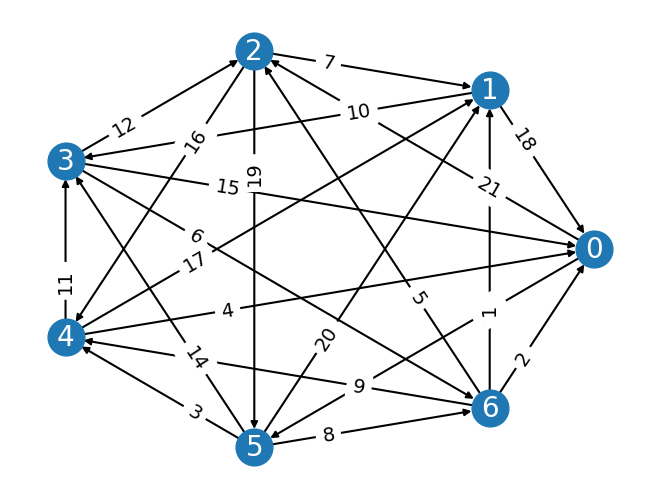

Time: 19.637375000000247
Split Cycle Winners: [3, 6]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [4]
223
010010010001010101001

[(1, 0), (0, 2), (3, 0), (4, 0), (0, 5), (6, 0), (2, 1), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (3, 6), (5, 4), (6, 4), (5, 6)]
checking critical edge 8: (1, 3)

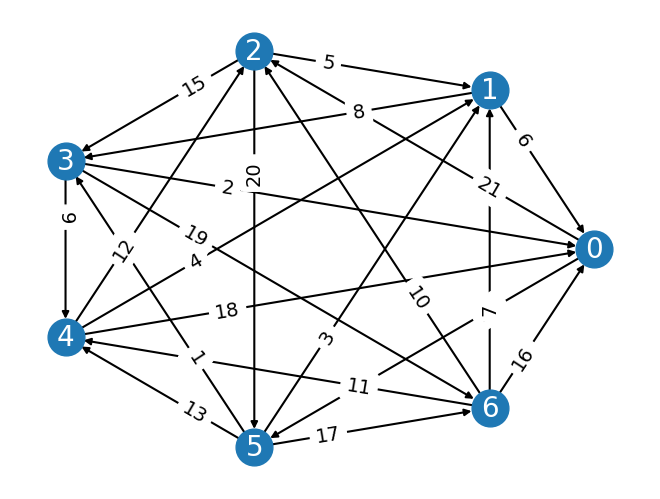

Time: 20.0318929999994
Split Cycle Winners: [1, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [3]
224
010010010001100011001

[(1, 0), (0, 2), (3, 0), (4, 0), (0, 5), (6, 0), (2, 1), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (4, 3), (3, 5), (3, 6), (5, 4), (6, 4), (5, 6)]
checking critical edge 5: (0, 5)

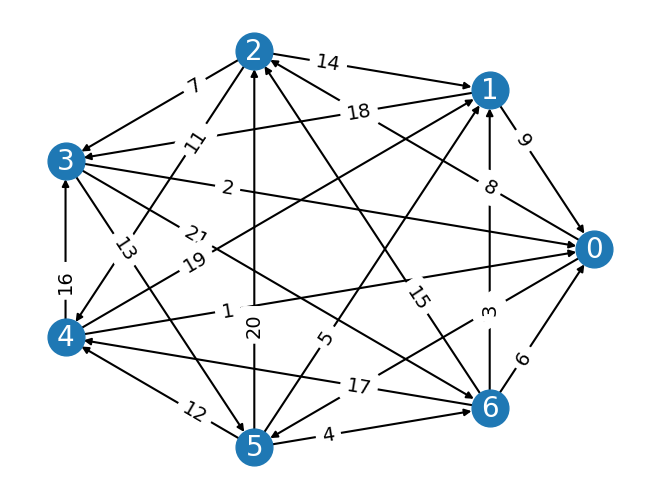

Time: 27.48097299999972
Split Cycle Winners: [0, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [5]
225
010010010001100101010

[(1, 0), (0, 2), (3, 0), (4, 0), (0, 5), (6, 0), (2, 1), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (3, 6), (5, 4), (4, 6), (6, 5)]
checking critical edge 1: (1, 0)

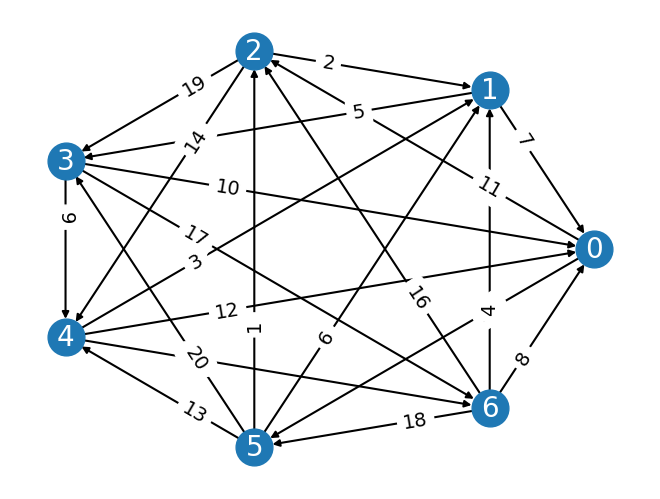

Time: 5.353573999998844
Split Cycle Winners: [1, 2, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [0]
226
010010010001100101101

[(1, 0), (0, 2), (3, 0), (4, 0), (0, 5), (6, 0), (2, 1), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (3, 6), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 010010010001100101101

227
010010100001011100001

[(1, 0), (0, 2), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (2, 6), (3, 4), (5, 3), (6, 3), (5, 4), (6, 4), (5, 6)]
checking critical edge 5: (0, 5)

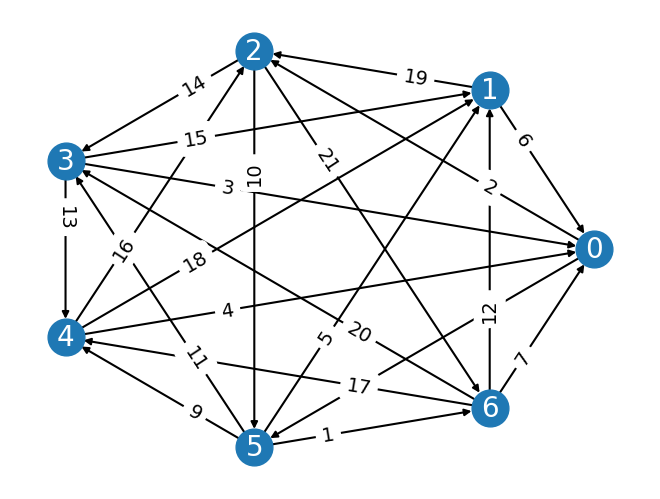

Time: 20.212032999999792
Split Cycle Winners: [0, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [5]
228
010010100001101100010

[(1, 0), (0, 2), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (2, 6), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
checking critical edge 7: (1, 2)

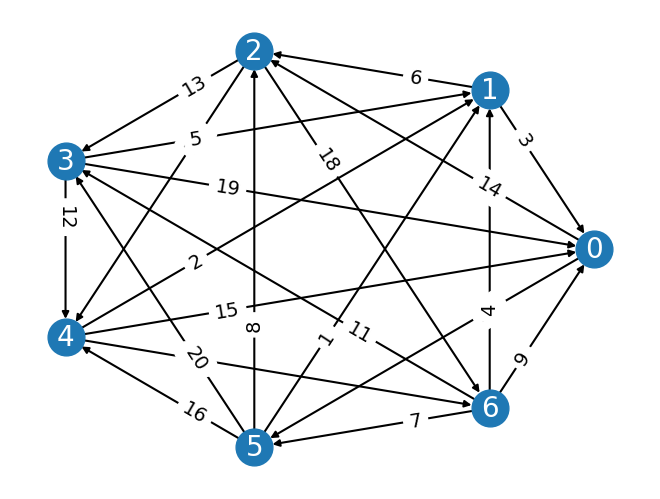

Time: 7.817737999997917
Split Cycle Winners: [0, 1]
Stable Voting Winner: [0]
Simple Stable Voting Winner: [2]
229
010010100001101100101

[(1, 0), (0, 2), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (2, 6), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 7: (1, 2)

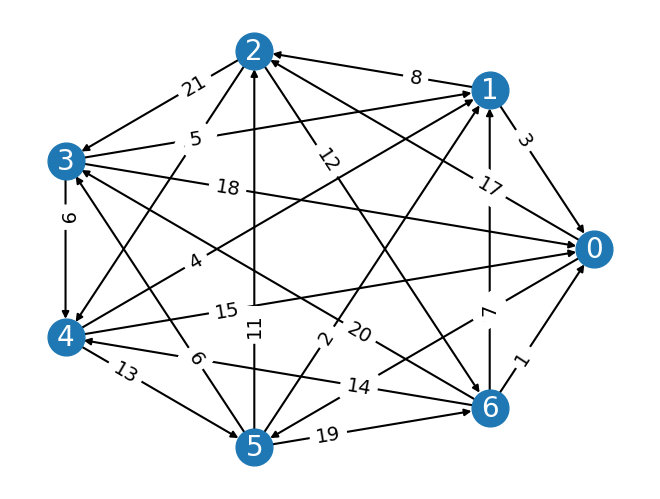

Time: 11.8329679999988
Split Cycle Winners: [1, 4, 5]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [2]
230
010010100001110100011

[(1, 0), (0, 2), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (5, 6)]
checking critical edge 15: (6, 2)

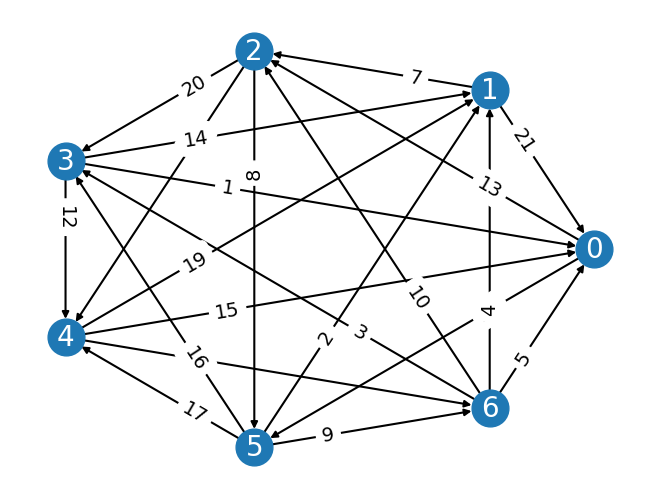

Time: 2.505988000000798
Split Cycle Winners: [4, 6]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [2]
231
011000000011010110000

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (5, 1), (1, 6), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (3, 5), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 011000000011010110000

232
011000000100110001001

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (3, 2), (2, 4), (2, 5), (6, 2), (4, 3), (5, 3), (3, 6), (5, 4), (6, 4), (5, 6)]
checking critical edge 10: (1, 5)

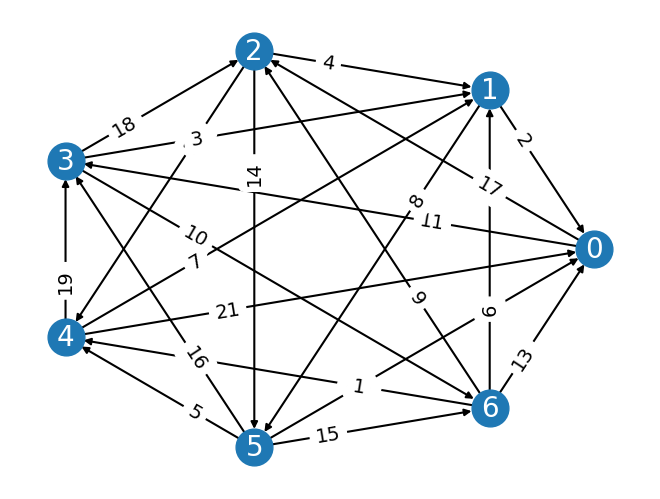

Time: 26.722139000001334
Split Cycle Winners: [1, 2]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [5]
233
011000000101001101000

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (2, 6), (3, 4), (5, 3), (3, 6), (5, 4), (6, 4), (6, 5)]
checking critical edge 9: (4, 1)

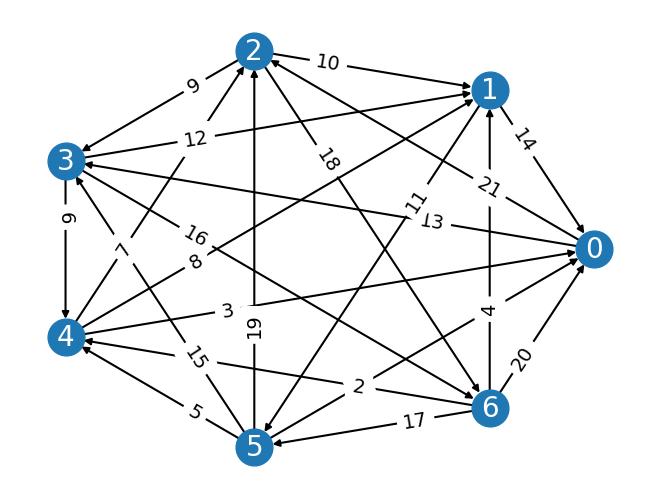

Time: 7.2254030000003695
Split Cycle Winners: [3, 4, 5]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [1]
234
011000000101010101001

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (3, 6), (5, 4), (6, 4), (5, 6)]
checking critical edge 10: (1, 5)

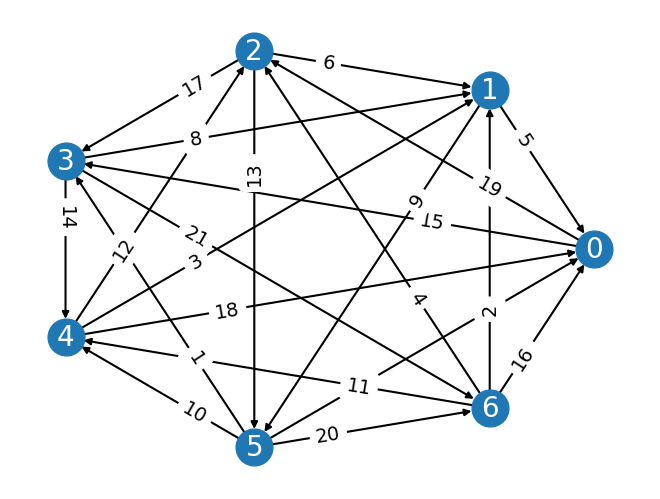

Time: 20.878833999999188
Split Cycle Winners: [1, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [5]
235
011000000101100011001

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (4, 3), (3, 5), (3, 6), (5, 4), (6, 4), (5, 6)]
checking critical edge 10: (1, 5)

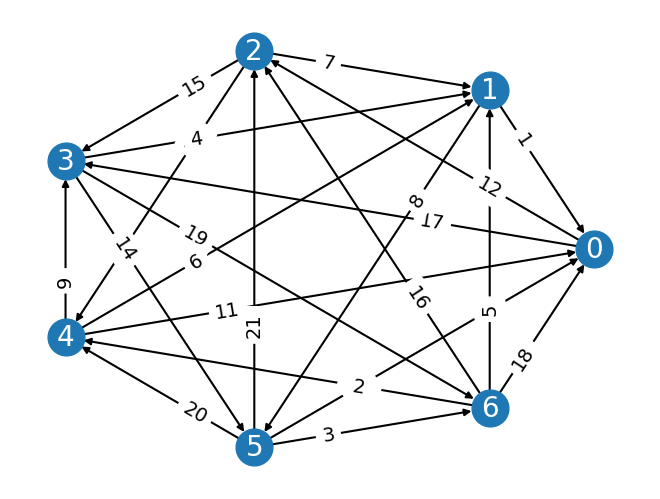

Time: 20.31853300000148
Split Cycle Winners: [1, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [5]
236
011000000101100101010

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (3, 6), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 011000000101100101010

237
011000000101100101101

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (3, 6), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 011000000101100101101

238
011000000101100110011

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (5, 4), (4, 6), (5, 6)]
checking critical edge 10: (1, 5)

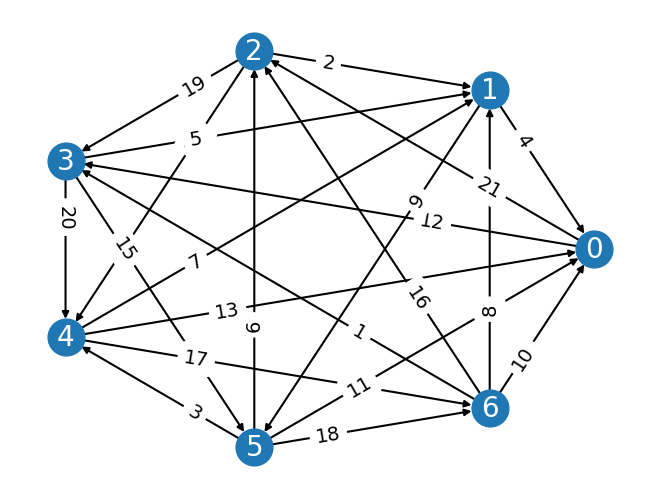

Time: 22.833615999999893
Split Cycle Winners: [0, 1]
Stable Voting Winner: [0]
Simple Stable Voting Winner: [5]
239
011000000101100110101

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 2: (0, 2)

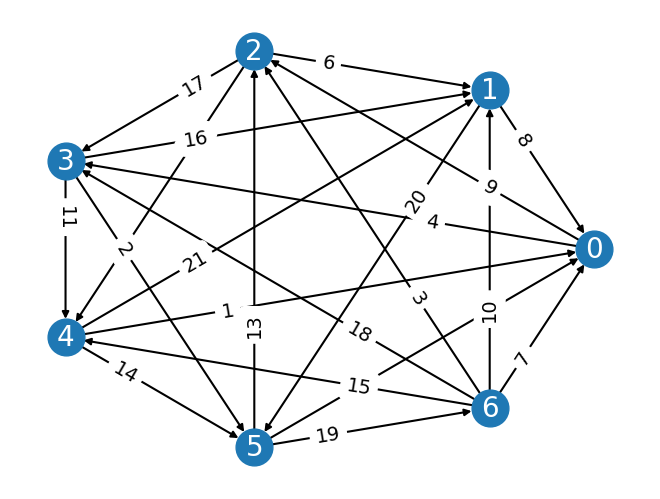

Time: 11.66747899999973
Split Cycle Winners: [0, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [2]
240
011000100000111001000

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (2, 4), (2, 5), (2, 6), (4, 3), (5, 3), (3, 6), (5, 4), (6, 4), (6, 5)]
checking critical edge 7: (1, 2)

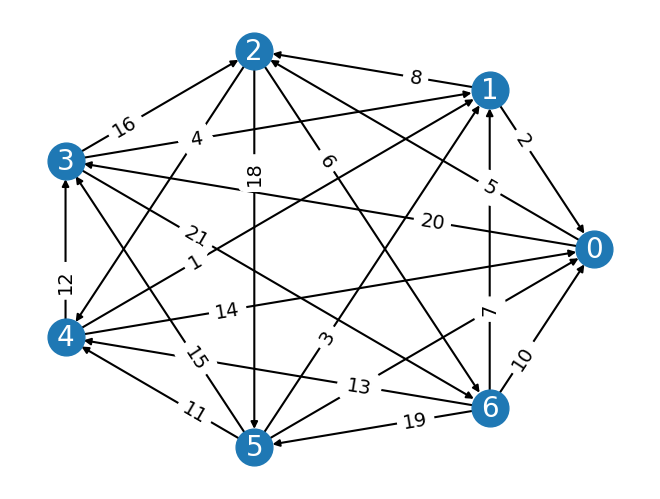

Time: 6.258894999999029
Split Cycle Winners: [1, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [2]
241
011000100000111100101

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (3, 2), (2, 4), (2, 5), (2, 6), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 19: (4, 5)

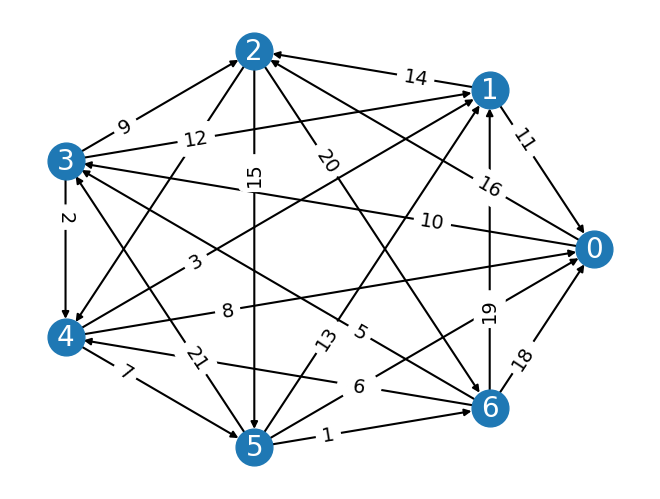

Time: 20.414410000001226
Split Cycle Winners: [2, 4]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [5]
242
011000100001011101000

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (2, 6), (3, 4), (5, 3), (3, 6), (5, 4), (6, 4), (6, 5)]
checking critical edge 17: (5, 3)

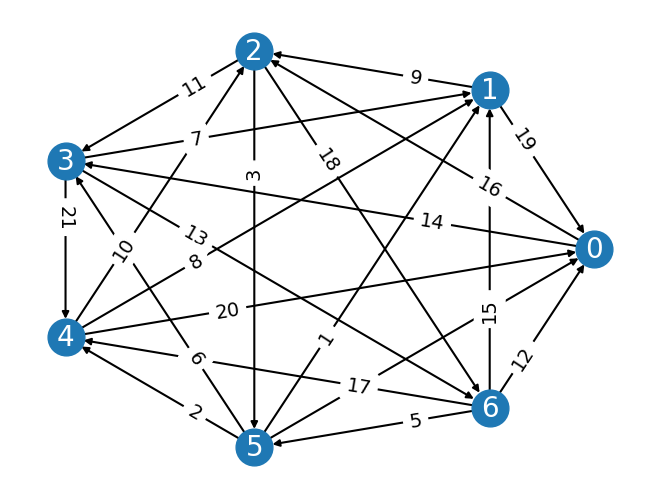

Time: 0.9324870000018564
Split Cycle Winners: [1, 2, 5]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [3]
243
011000100001101011000

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (2, 6), (4, 3), (3, 5), (3, 6), (5, 4), (6, 4), (6, 5)]
checking critical edge 16: (4, 3)

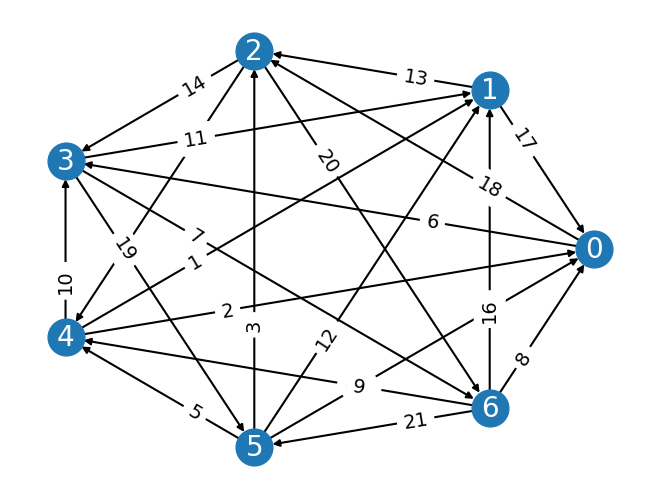

Time: 9.938741999998456
Split Cycle Winners: [1, 4]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [3]
244
011000100001101101100

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (2, 6), (3, 4), (5, 3), (3, 6), (4, 5), (6, 4), (6, 5)]
checking critical edge 1: (1, 0)

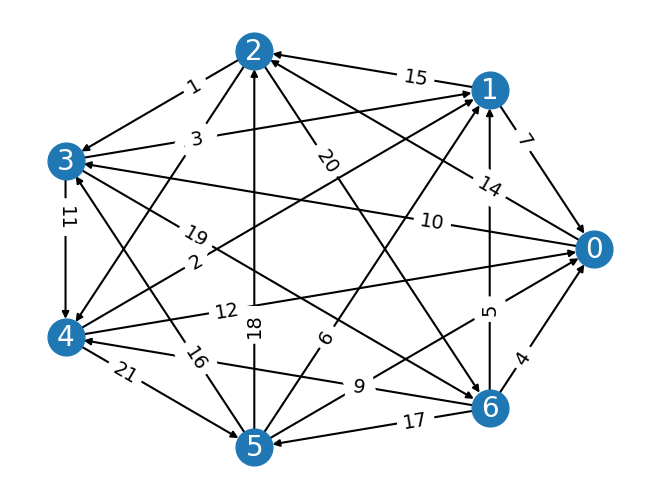

Time: 21.84177400000044
Split Cycle Winners: [1, 3, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [0]
245
011000100001101110101

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (2, 6), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 011000100001101110101

246
011000100001110101101

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (2, 5), (6, 2), (3, 4), (5, 3), (3, 6), (4, 5), (6, 4), (5, 6)]
checking critical edge 19: (4, 5)

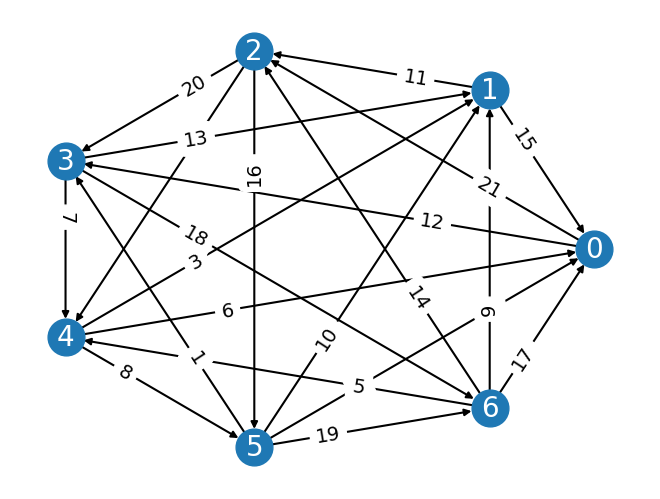

Time: 17.434676999997464
Split Cycle Winners: [1, 4]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [5]
247
011000100001110110101

[(1, 0), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (6, 1), (2, 3), (2, 4), (2, 5), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 011000100001110110101

248
100000000010000000000

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (5, 1), (1, 6), (3, 2), (4, 2), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 100000000010000000000

249
100000000010000100100

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (5, 1), (1, 6), (3, 2), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 100000000010000100100

250
100000000010100000100

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (4, 1), (5

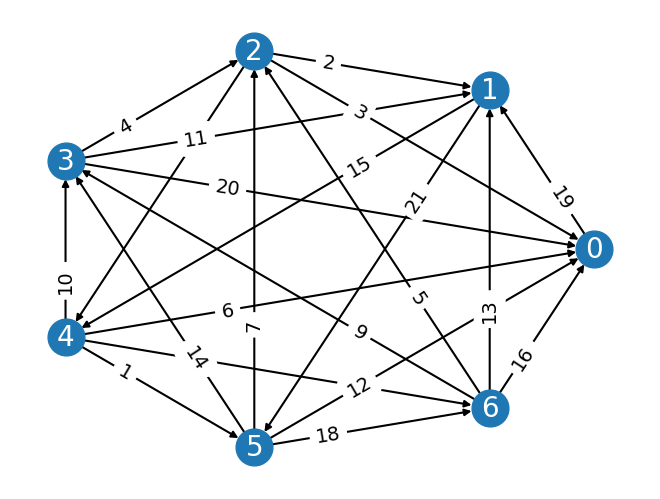

Time: 3.8225659999989148
Split Cycle Winners: [2, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [4]
264
100000001101000001101

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (4, 3), (5, 3), (3, 6), (4, 5), (6, 4), (5, 6)]
checking critical edge 20: (6, 4)

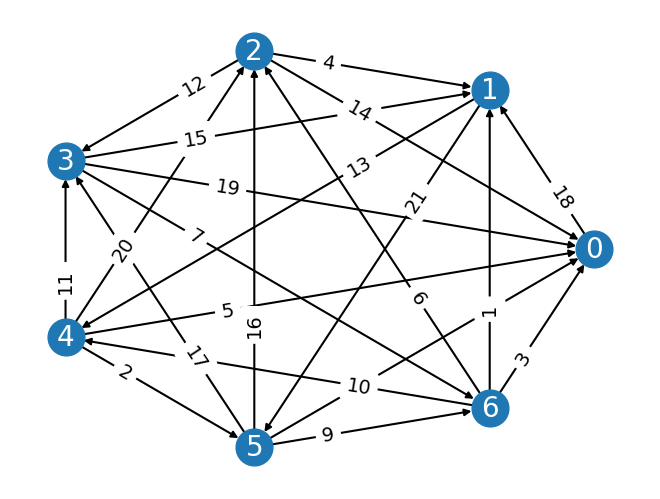

Time: 1.742895999999746
Split Cycle Winners: [3, 6]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [4]
265
100000001101000100010

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 100000001101000100010

266
100000010000000000000

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (1, 3), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 100000010000000000000

267
100000010000000001000

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (1, 3), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (6, 2), (4, 3), (5, 3), (3, 6), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 100000010000000001000

268
100000010000000100100

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (1, 3), (4, 1), (5,

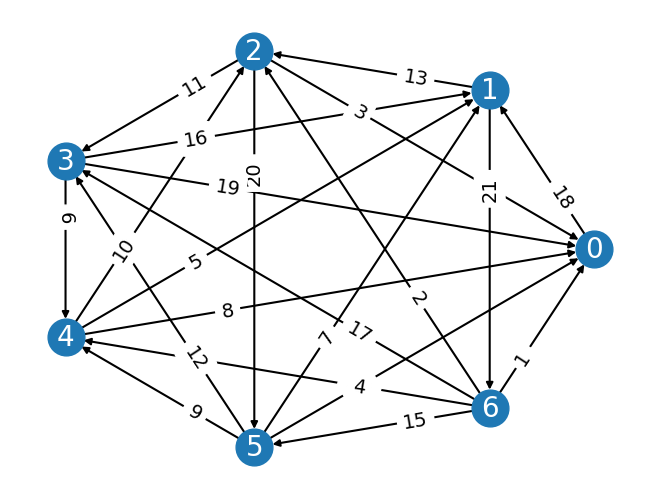

Time: 2.655650999997306
Split Cycle Winners: [3, 4]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [2]
300
100000100011100100100

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (1, 6), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (6, 5)]
checking critical edge 14: (5, 2)

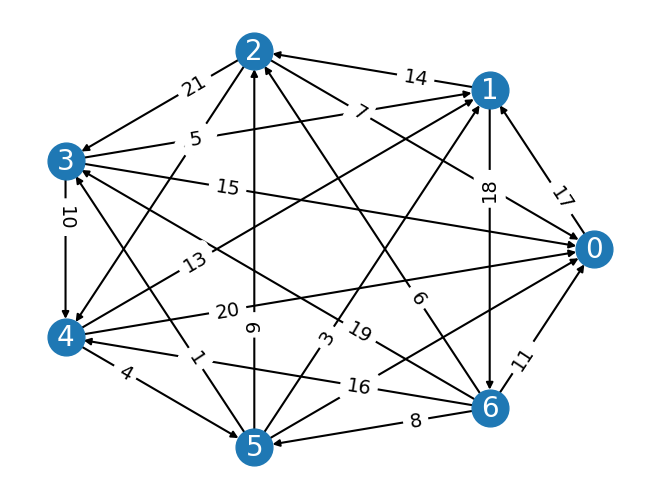

Time: 3.1454570000023523
Split Cycle Winners: [4, 5]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [2]
301
100000100100001000000

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (3, 2), (4, 2), (5, 2), (2, 6), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 100000100100001000000

302
100000100100010000001

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (3, 2), (4, 2), (2, 5), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 100000100100010000001

303
100000100101000001000

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (4, 3), (5, 3), (3, 6), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 100000100101000001000

304
100000100101000100000

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1

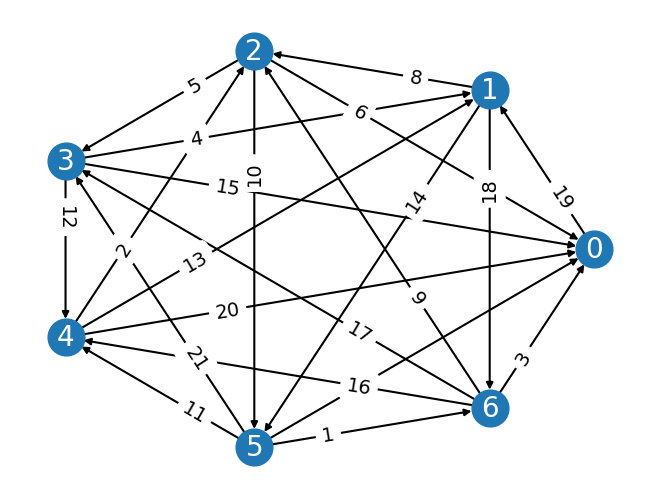

Time: 24.529762000001938
Split Cycle Winners: [2, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [5]
309
100000100111100100010

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (1, 6), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
checking critical edge 1: (0, 1)

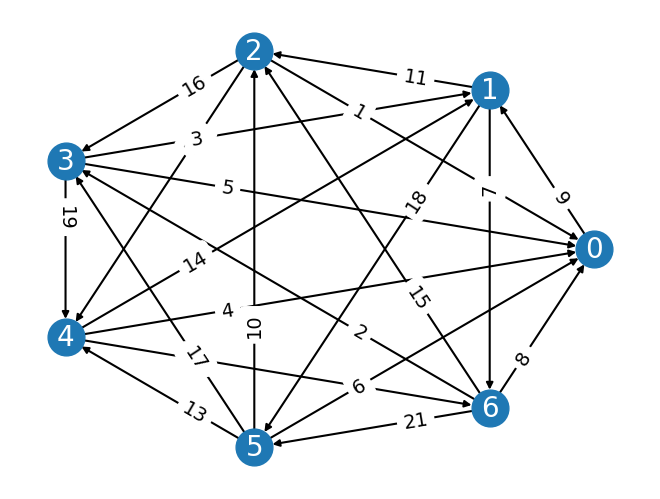

Time: 18.785392000001593
Split Cycle Winners: [0, 2]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [1]
310
100000101000010000000

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (3, 2), (4, 2), (2, 5), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 100000101000010000000

311
100000101000010000001

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (3, 2), (4, 2), (2, 5), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 100000101000010000001

312
100000101000010000101

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (3, 2), (4, 2), (2, 5), (6, 2), (4, 3), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 100000101000010000101

313
100000101000011000101

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5

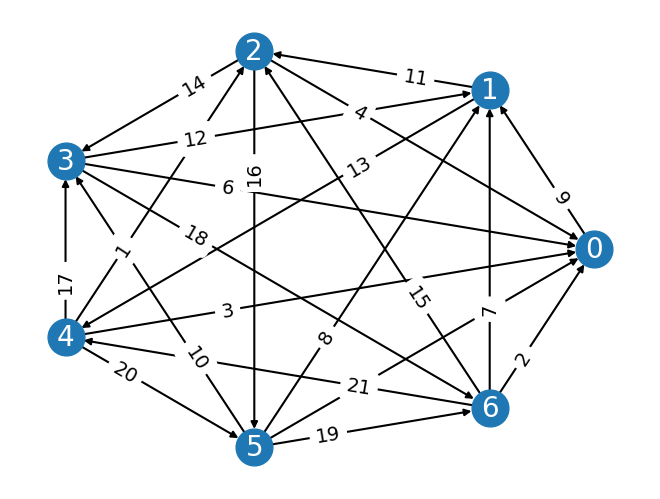

Time: 2.939566000000923
Split Cycle Winners: [0, 2, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [1]
326
100000101001010100010

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 100000101001010100010

327
100000101001010100111

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (4, 6), (5, 6)]
No counterexamples of size 7 for bitstring 100000101001010100111

328
100000101001100010111

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (4, 3), (3, 5), (6, 3), (4, 5), (4, 6), (5, 6)]
No counterexamples of size 7 for bitstring 100000101001100010111

329
100000101001100100110

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), 

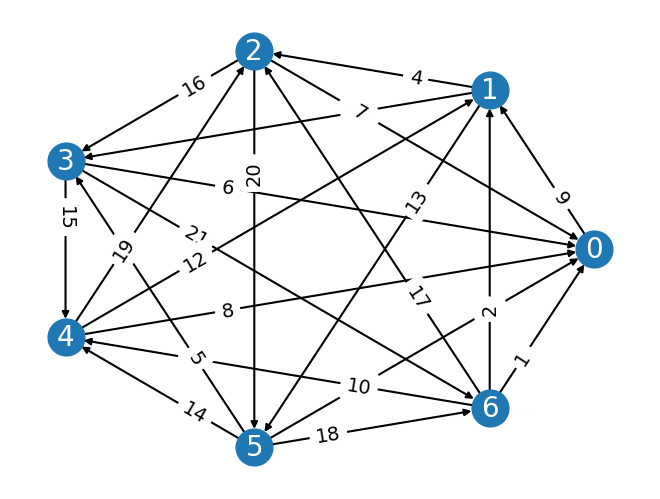

Time: 10.372245999998995
Split Cycle Winners: [0, 3, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [1]
353
100000110101100011001

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (4, 3), (3, 5), (3, 6), (5, 4), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 100000110101100011001

354
100000110101100101010

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (3, 6), (5, 4), (4, 6), (6, 5)]
checking critical edge 1: (0, 1)

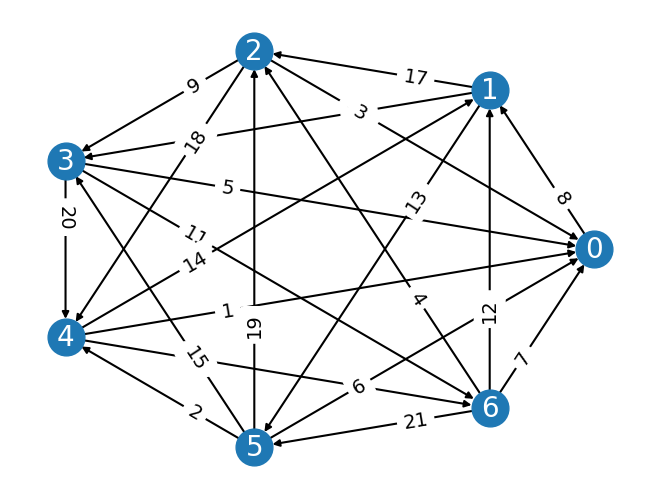

Time: 12.220789999999397
Split Cycle Winners: [0, 3, 6]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [1]
355
100000110101100101101

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (3, 6), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 100000110101100101101

356
100000110101100110011

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (5, 4), (4, 6), (5, 6)]
checking critical edge 1: (0, 1)

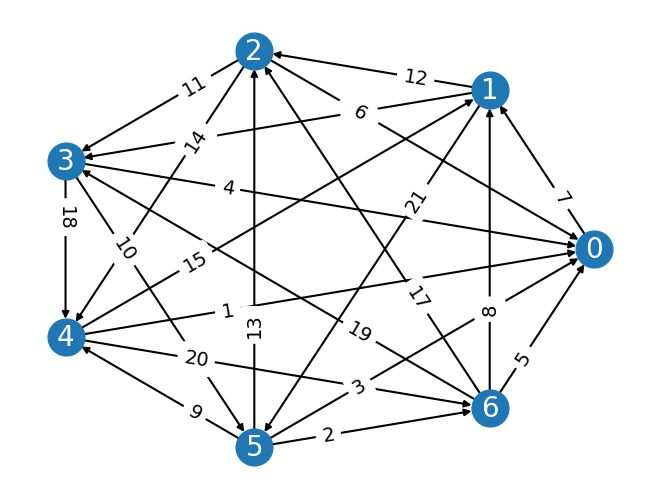

Time: 11.412261000001308
Split Cycle Winners: [0, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [1]
357
100000111001010101010

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (3, 6), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 100000111001010101010

358
100000111001010110101

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 1: (0, 1)

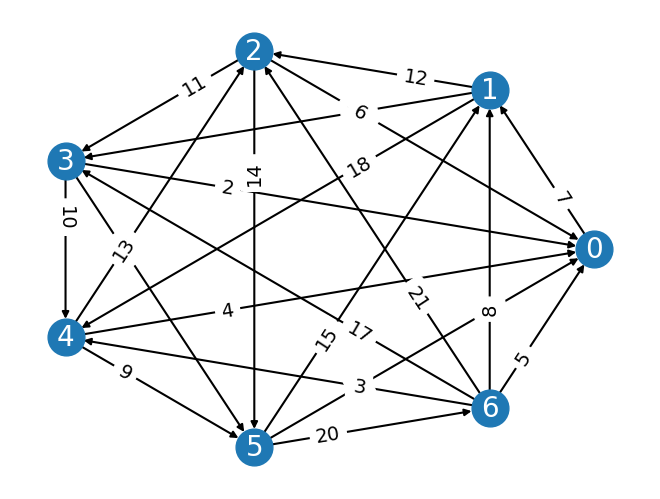

Time: 2.022569000000658
Split Cycle Winners: [0, 5]
Stable Voting Winner: [5]
Simple Stable Voting Winner: [1]
359
100000111001100101110

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (1, 4), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (3, 6), (4, 5), (4, 6), (6, 5)]
checking critical edge 1: (0, 1)

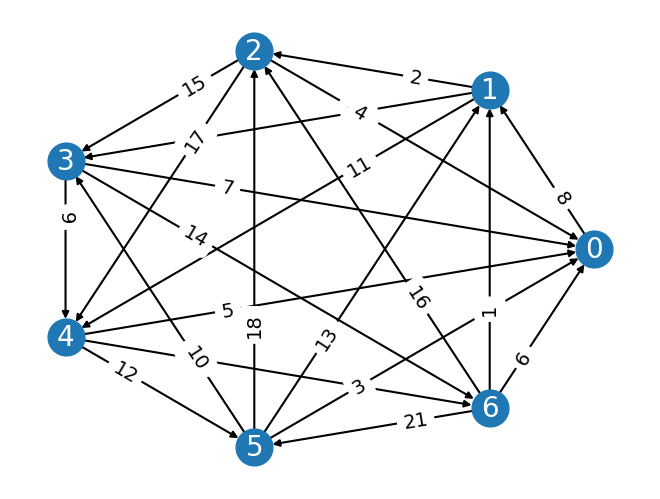

Time: 12.185476000002382
Split Cycle Winners: [0, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [1]
360
100001100101000100010

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (0, 6), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 100001100101000100010

361
100001100101000100101

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (0, 6), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 100001100101000100101

362
100001101001000100110

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (0, 6), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 100001101001000100110

363
100001110001000110101

[(0, 1), (2, 0), (3, 0), (4, 0), (5, 0), (0, 6), (1, 2), (1, 3), (4, 1), (5

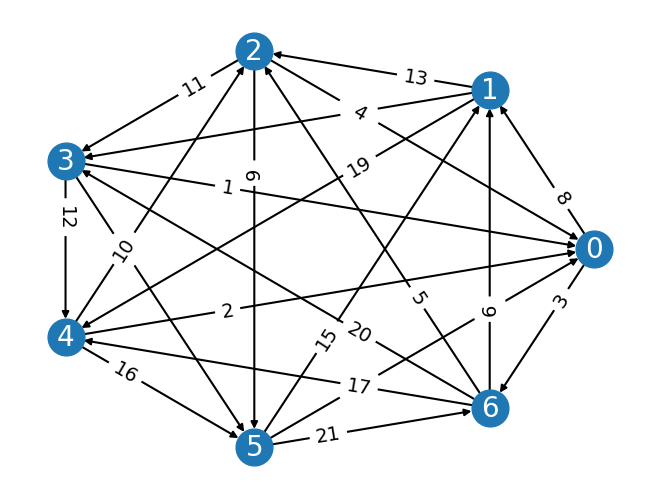

Time: 25.817848999999114
Split Cycle Winners: [0, 5]
Stable Voting Winner: [5]
Simple Stable Voting Winner: [1]
365
100010001101000100101

[(0, 1), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (2, 1), (3, 1), (1, 4), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 12: (2, 3)

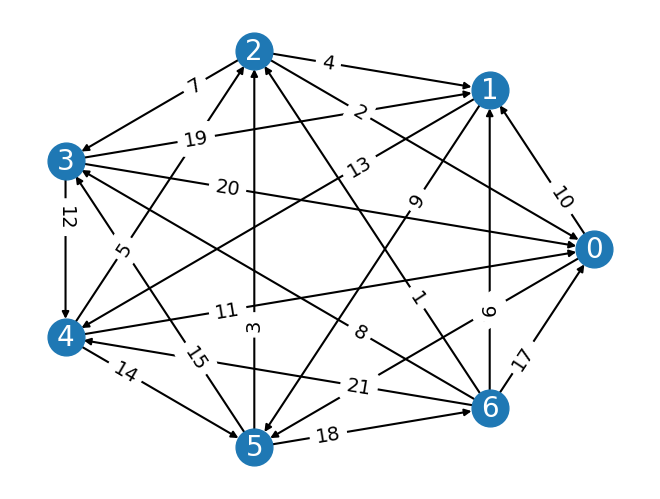

Time: 16.203788999999233
Split Cycle Winners: [2, 5]
Stable Voting Winner: [5]
Simple Stable Voting Winner: [3]
366
100010100010001000000

[(0, 1), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (1, 6), (3, 2), (4, 2), (5, 2), (2, 6), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
checking critical edge 5: (0, 5)

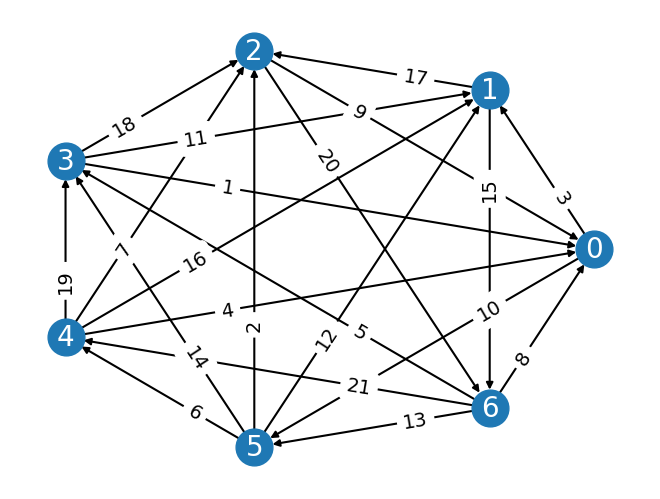

Time: 22.400386000001163
Split Cycle Winners: [0, 1]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [5]
367
100010100011100100100

[(0, 1), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (1, 6), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (6, 5)]
checking critical edge 14: (5, 2)

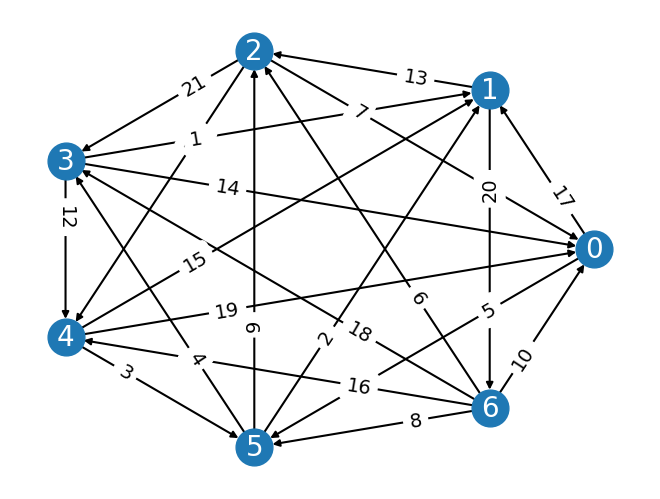

Time: 1.9402010000012524
Split Cycle Winners: [4, 5]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [2]
368
100010100100100000001

[(0, 1), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (5, 6)]
checking critical edge 13: (2, 4)

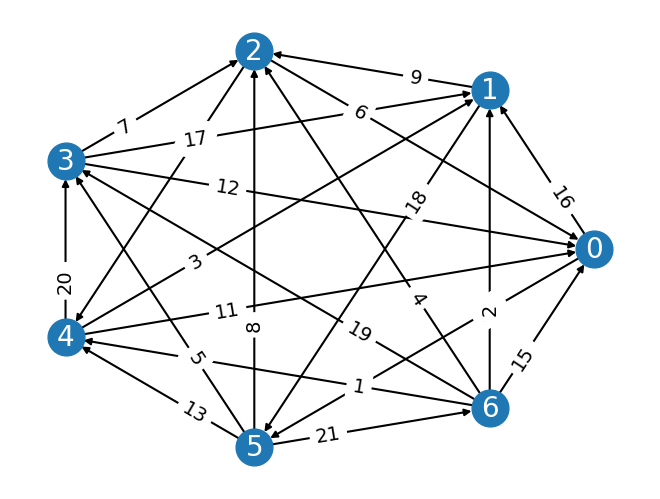

Time: 12.682090000002063
Split Cycle Winners: [0, 2]
Stable Voting Winner: [0]
Simple Stable Voting Winner: [4]
369
100010100101000100011

[(0, 1), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (5, 6)]
No counterexamples of size 7 for bitstring 100010100101000100011

370
100010101000100000010

[(0, 1), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 100010101000100000010

371
100010101000100000101

[(0, 1), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 100010101000100000101

372
100010110000001100000

[(0, 1), (2, 0), (3, 0), (4, 0), (0, 5), (6, 0), (1, 2), (1, 3), (4, 1), (5

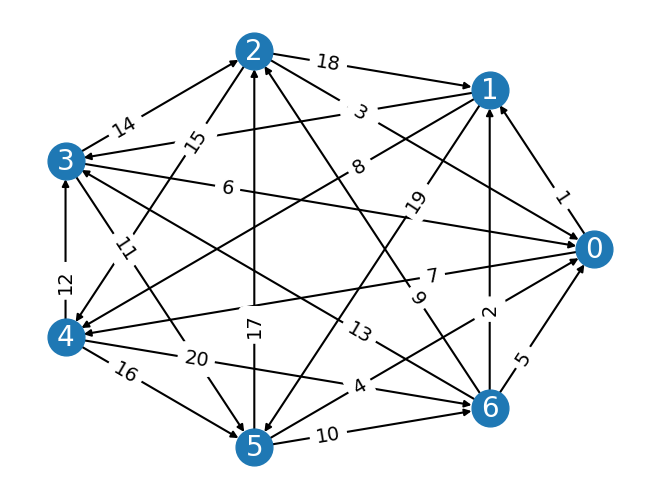

Time: 23.456869999998162
Split Cycle Winners: [0, 2]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [4]
380
100100011101000110111

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (2, 1), (1, 3), (1, 4), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (4, 6), (5, 6)]
checking critical edge 1: (0, 1)

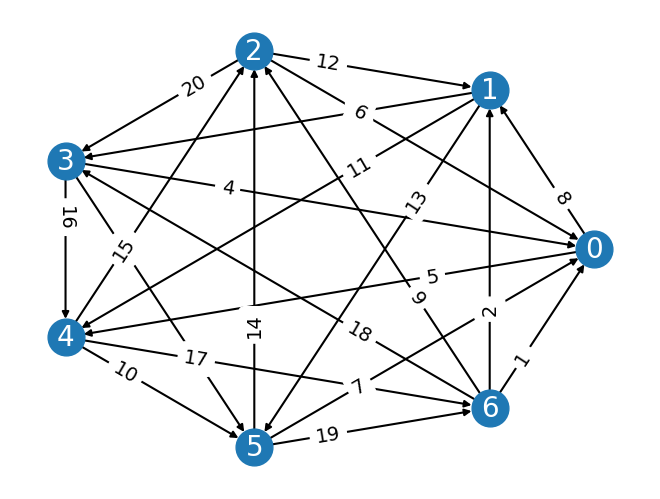

Time: 34.65115999999762
Split Cycle Winners: [0, 2, 4]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [1]
381
100100100010010000101

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (1, 6), (3, 2), (4, 2), (2, 5), (6, 2), (4, 3), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 100100100010010000101

382
100100100100001000000

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (3, 2), (4, 2), (5, 2), (2, 6), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 100100100100001000000

383
100100100100001000101

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (3, 2), (4, 2), (5, 2), (2, 6), (4, 3), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 100100100100001000101

384
100100100100010000000

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), 

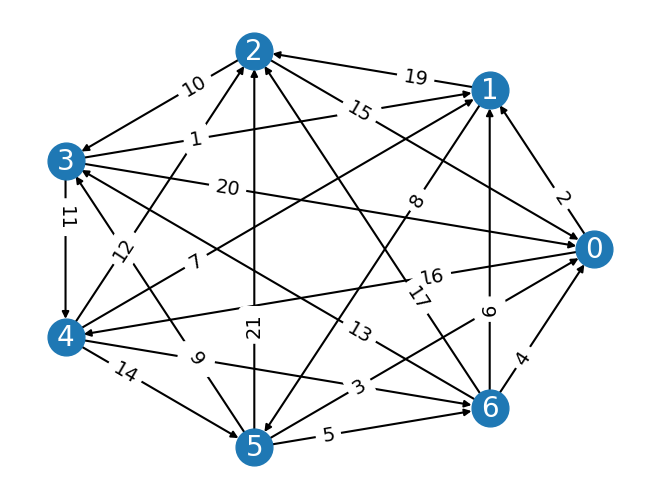

Time: 32.175350999998045
Split Cycle Winners: [1, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [5]
386
100100101000100000110

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (4, 5), (4, 6), (6, 5)]
checking critical edge 17: (5, 3)

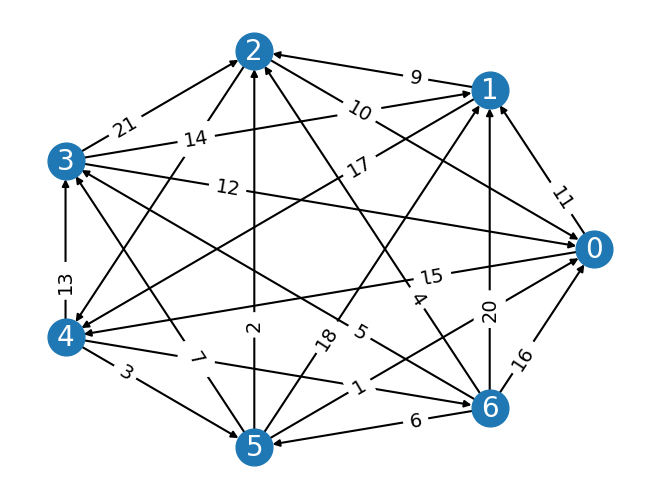

Time: 5.982356999997137
Split Cycle Winners: [4, 5]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [3]
387
100100101101010010011

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (1, 5), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (4, 3), (3, 5), (6, 3), (5, 4), (4, 6), (5, 6)]
checking critical edge 12: (2, 3)

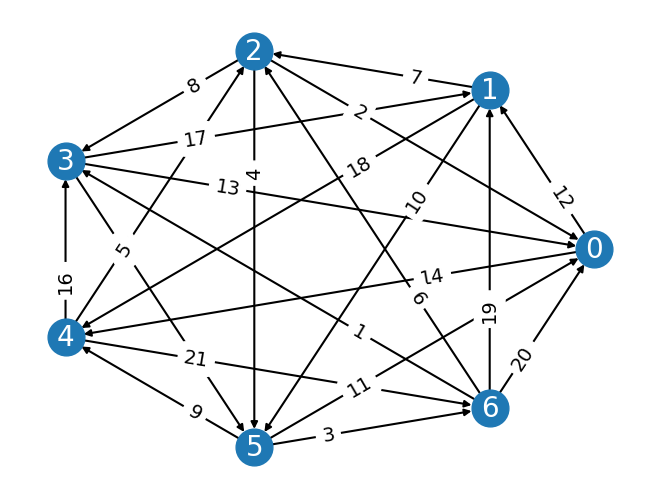

Time: 22.79832600000009
Split Cycle Winners: [2, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [3]
388
100100101101100010111

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (4, 3), (3, 5), (6, 3), (4, 5), (4, 6), (5, 6)]
checking critical edge 21: (5, 6)

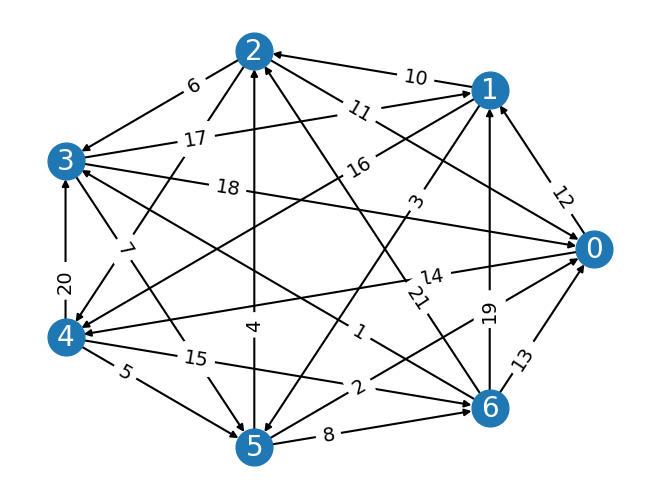

Time: 40.3728689999989
Split Cycle Winners: [4, 5]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [6]
389
100100110000001010000

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (2, 6), (4, 3), (3, 5), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 100100110000001010000

390
100100110000001100100

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (2, 6), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 100100110000001100100

391
100100110001000001100

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (4, 3), (5, 3), (3, 6), (4, 5), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 100100110001000001100

392
100100110001000010101

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 

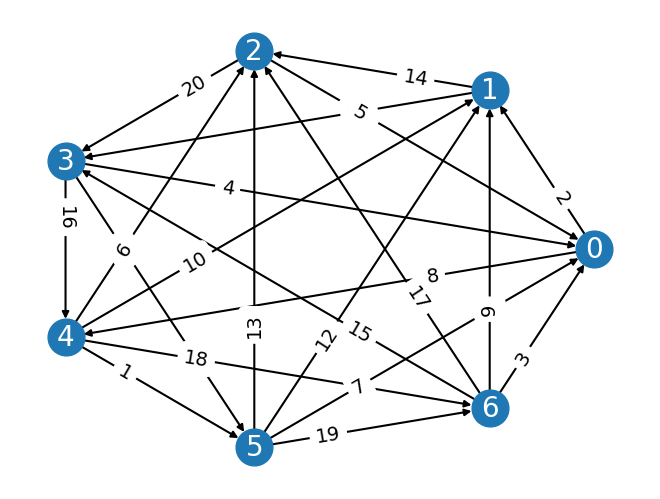

Time: 3.229987999999139
Split Cycle Winners: [0, 1]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [4]
394
100100110101010110011

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (3, 5), (6, 3), (5, 4), (4, 6), (5, 6)]
checking critical edge 1: (0, 1)

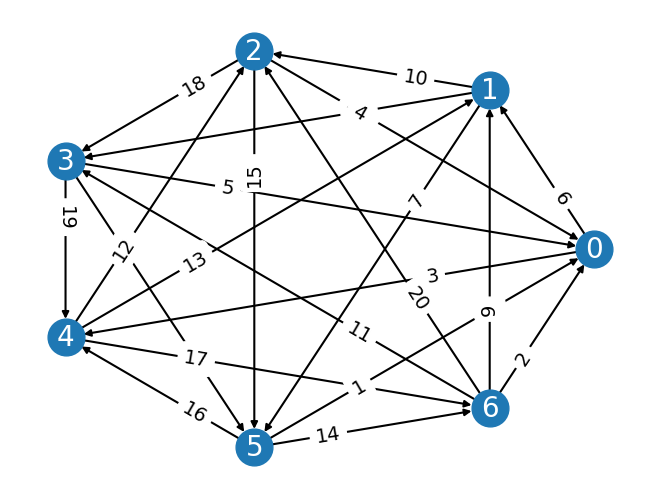

Time: 17.10200800000166
Split Cycle Winners: [0, 5, 6]
Stable Voting Winner: [5]
Simple Stable Voting Winner: [1]
395
100100110101100110111

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (4, 6), (5, 6)]
checking critical edge 21: (5, 6)

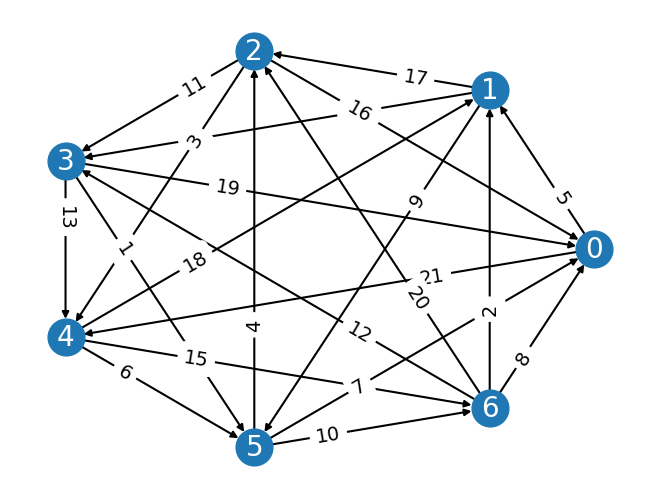

Time: 25.73898399999962
Split Cycle Winners: [3, 5]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [6]
396
100100111001010110111

[(0, 1), (2, 0), (3, 0), (0, 4), (5, 0), (6, 0), (1, 2), (1, 3), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (4, 6), (5, 6)]
checking critical edge 1: (0, 1)

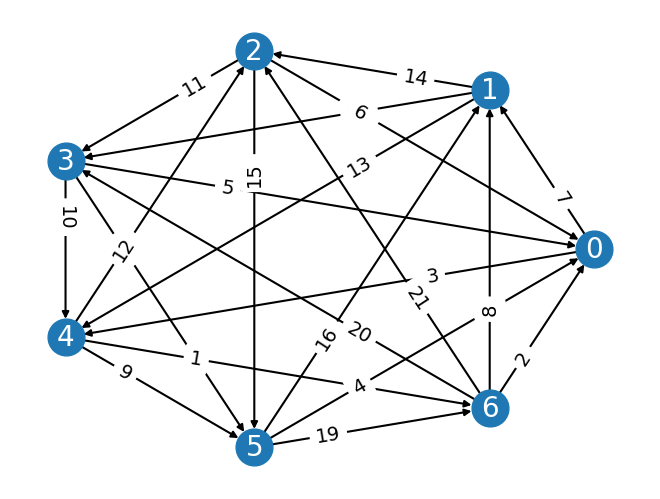

Time: 34.84976299999835
Split Cycle Winners: [0, 5]
Stable Voting Winner: [5]
Simple Stable Voting Winner: [1]
397
101000001101000110101

[(0, 1), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (2, 1), (3, 1), (1, 4), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 13: (4, 2)

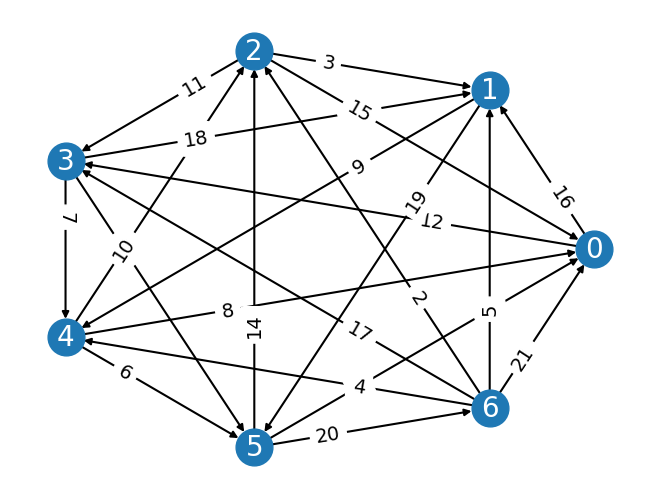

Time: 5.65736200000174
Split Cycle Winners: [3, 4]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [2]
398
101000100011100110100

[(0, 1), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (1, 6), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (6, 5)]
checking critical edge 14: (5, 2)

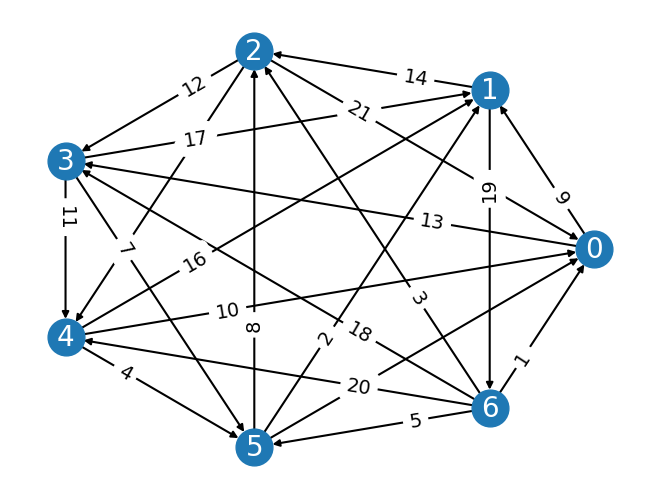

Time: 3.4579720000001544
Split Cycle Winners: [1, 5]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [2]
399
101000100100100100010

[(0, 1), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 101000100100100100010

400
101000100100100100100

[(0, 1), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 101000100100100100100

401
101000100101100110101

[(0, 1), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 101000100101100110101

402
101000101000010100100

[(0, 1), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5

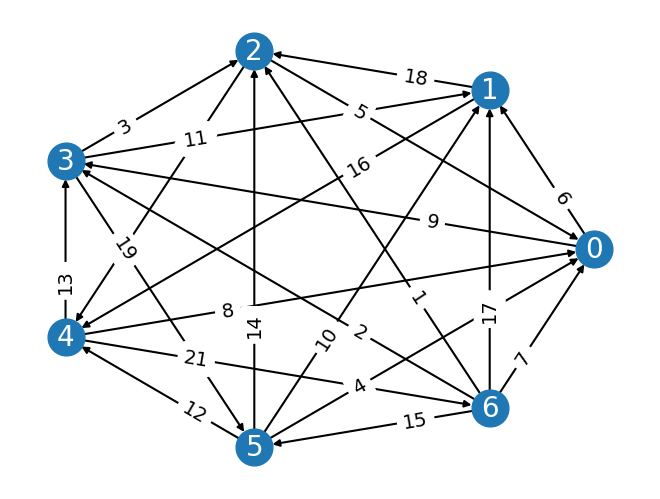

Time: 1.0014479999990726
Split Cycle Winners: [0, 1]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [3]
404
101000101000100010101

[(0, 1), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (4, 3), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 101000101000100010101

405
101000101000100100110

[(0, 1), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 101000101000100100110

406
101000110000001110000

[(0, 1), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (3, 2), (4, 2), (5, 2), (2, 6), (3, 4), (3, 5), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 101000110000001110000

407
101000110000010010001

[(0, 1), (2, 0), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5

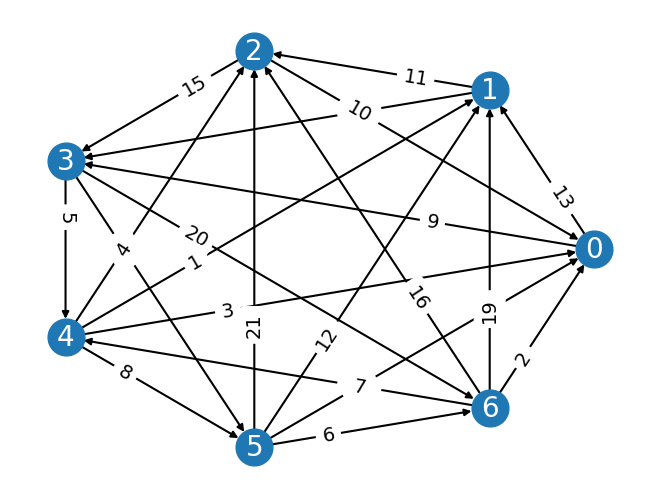

Time: 29.09798199999932
Split Cycle Winners: [3, 4]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [5]
416
110000010100100010001

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (1, 3), (4, 1), (1, 5), (6, 1), (3, 2), (2, 4), (5, 2), (6, 2), (4, 3), (3, 5), (6, 3), (5, 4), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 110000010100100010001

417
110000010101100110101

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (2, 1), (1, 3), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
checking critical edge 2: (0, 2)

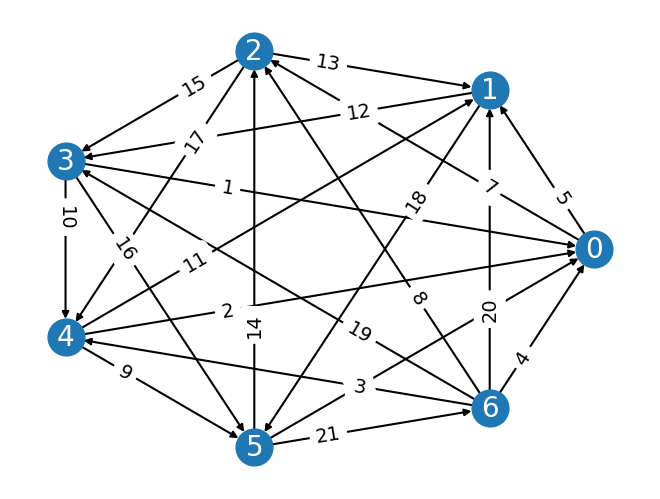

Time: 8.185277000000497
Split Cycle Winners: [0, 5]
Stable Voting Winner: [5]
Simple Stable Voting Winner: [2]
418
110000100010011000000

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (1, 6), (3, 2), (4, 2), (2, 5), (2, 6), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
checking critical edge 11: (1, 6)

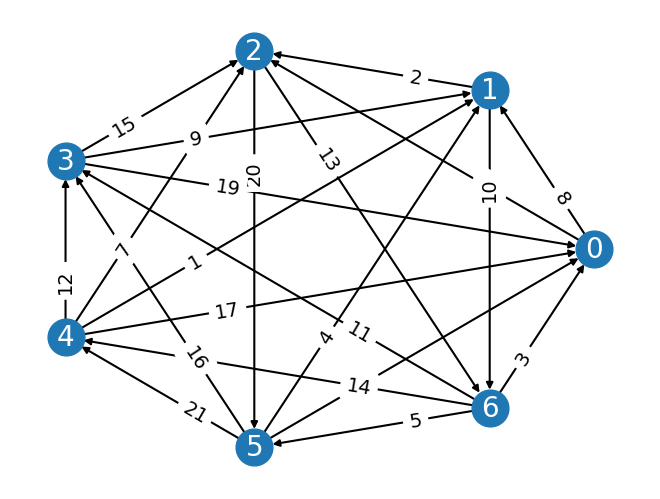

Time: 10.949636999997892
Split Cycle Winners: [1, 3]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [6]
419
110000100010110000101

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (1, 6), (3, 2), (2, 4), (2, 5), (6, 2), (4, 3), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 110000100010110000101

420
110000100011010100010

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (1, 6), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
checking critical edge 1: (0, 1)

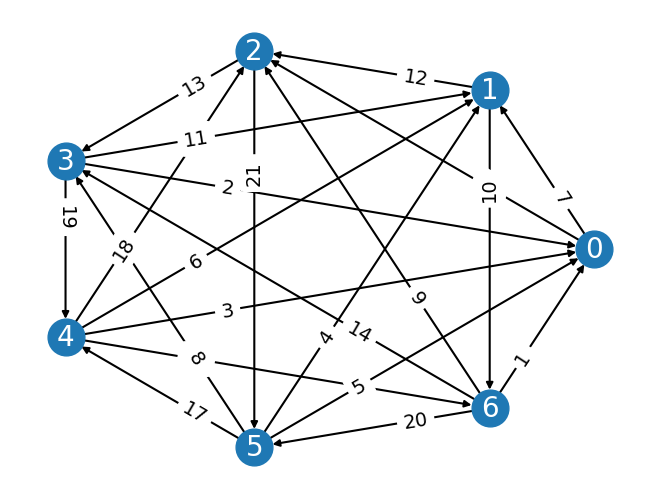

Time: 19.15565400000196
Split Cycle Winners: [0, 3, 6]
Stable Voting Winner: [3]
Simple Stable Voting Winner: [1]
421
110000100011010100101

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (1, 6), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 110000100011010100101

422
110000100011100100110

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (1, 6), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 110000100011100100110

423
110000100011110100100

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (5, 1), (1, 6), (2, 3), (2, 4), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (6, 5)]
checking critical edge 2: (0, 2)

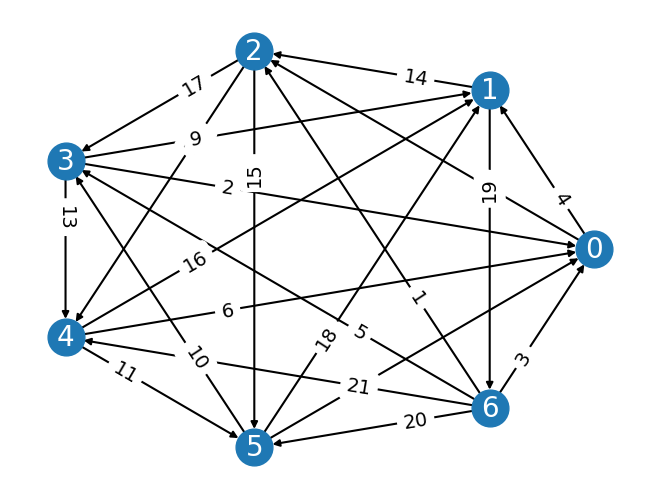

Time: 4.5513930000015534
Split Cycle Winners: [0, 1]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [2]
424
110000100100110000000

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (3, 2), (2, 4), (2, 5), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 110000100100110000000

425
110000100100110000001

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (3, 2), (2, 4), (2, 5), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (5, 6)]
checking critical edge 16: (4, 3)

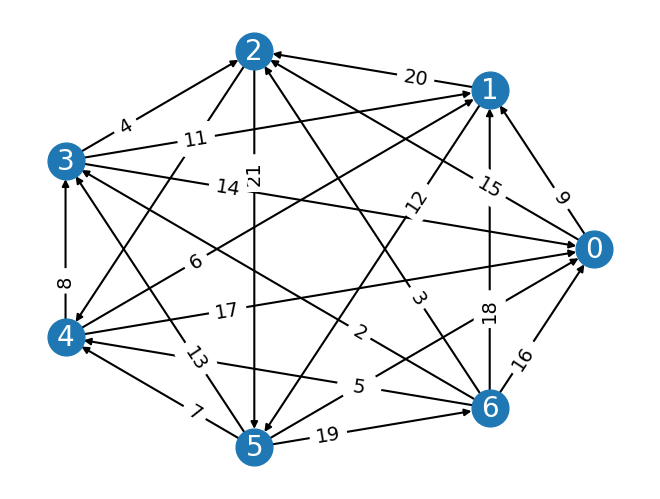

Time: 7.666944999997213
Split Cycle Winners: [1, 4]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [3]
426
110000100101001100000

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (5, 2), (2, 6), (3, 4), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 110000100101001100000

427
110000100101010100011

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (5, 6)]
checking critical edge 16: (3, 4)

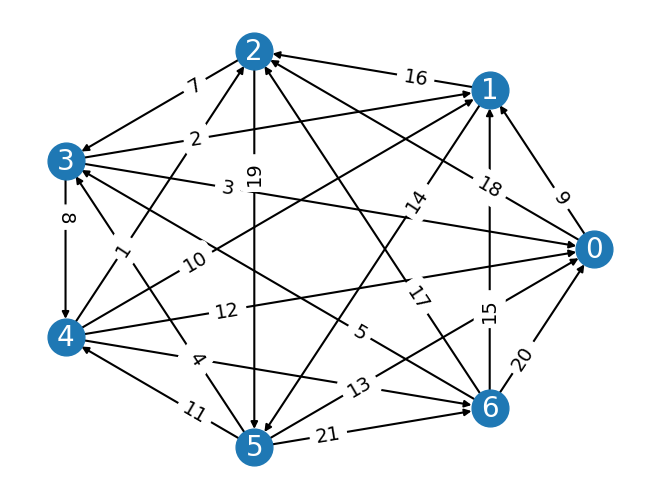

Time: 30.475387000005867
Split Cycle Winners: [1, 3]
Stable Voting Winner: [1]
Simple Stable Voting Winner: [4]
428
110000100101100010001

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (4, 3), (3, 5), (6, 3), (5, 4), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 110000100101100010001

429
110000100101100100010

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 110000100101100100010

430
110000100101100100100

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (4, 1), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 110000100101100100100

431
110000101000011000000

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5

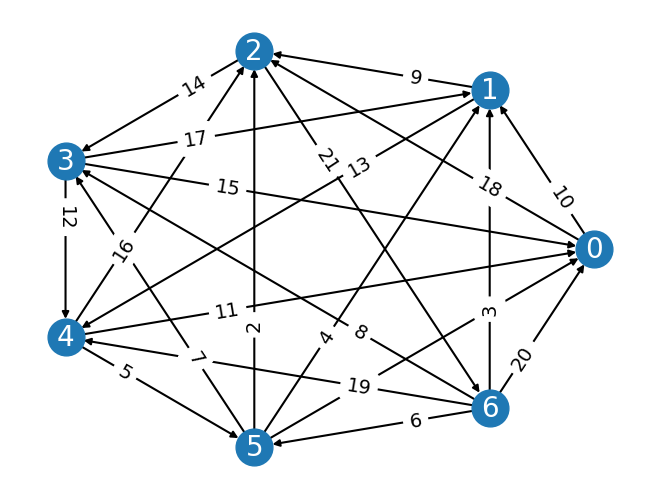

Time: 2.9997480000020005
Split Cycle Winners: [2, 5]
Stable Voting Winner: [2]
Simple Stable Voting Winner: [3]
436
110000101001010100111

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (4, 5), (4, 6), (5, 6)]
No counterexamples of size 7 for bitstring 110000101001010100111

437
110000101001100000000

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (4, 3), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 110000101001100000000

438
110000101001100010010

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5, 1), (6, 1), (2, 3), (2, 4), (5, 2), (6, 2), (4, 3), (3, 5), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 110000101001100010010

439
110000101001100010101

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (5

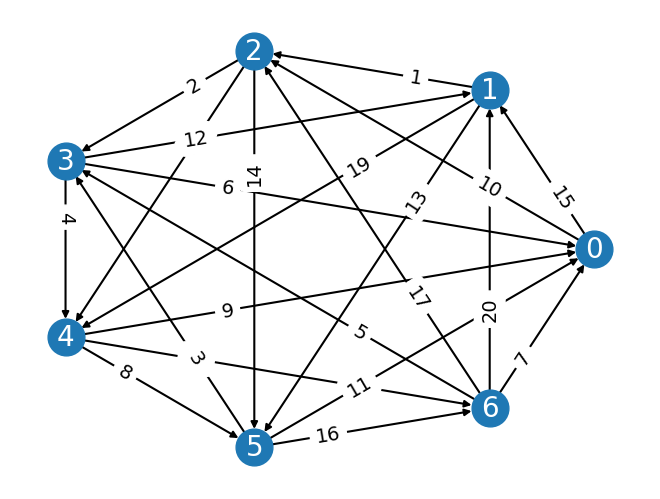

Time: 10.41541000000143
Split Cycle Winners: [2, 3, 5]
Stable Voting Winner: [5]
Simple Stable Voting Winner: [0]
442
110000110000110010001

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (3, 2), (2, 4), (2, 5), (6, 2), (4, 3), (3, 5), (6, 3), (5, 4), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 110000110000110010001

443
110000110000110100010

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (3, 2), (2, 4), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (4, 6), (6, 5)]
No counterexamples of size 7 for bitstring 110000110000110100010

444
110000110001001100000

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (2, 6), (3, 4), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 110000110001001100000

445
110000110001001110000

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), 

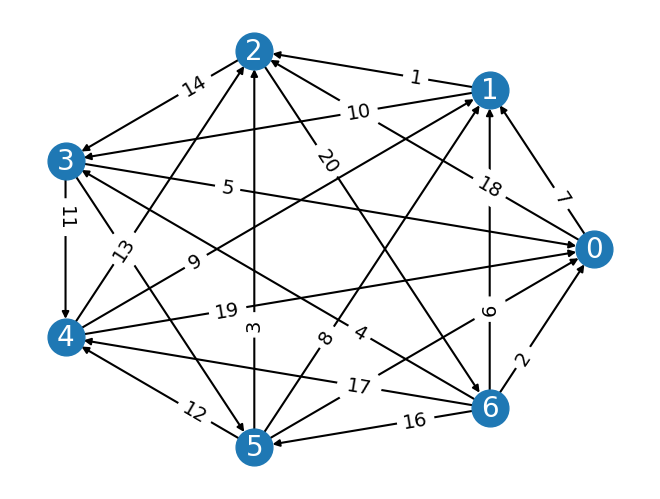

Time: 3.45980899999995
Split Cycle Winners: [1, 4]
Stable Voting Winner: [4]
Simple Stable Voting Winner: [3]
446
110000110001001110101

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (5, 2), (2, 6), (3, 4), (3, 5), (6, 3), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 110000110001001110101

447
110000110001010001000

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (4, 3), (5, 3), (3, 6), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 110000110001010001000

448
110000110001010100000

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (6, 1), (2, 3), (4, 2), (2, 5), (6, 2), (3, 4), (5, 3), (6, 3), (5, 4), (6, 4), (6, 5)]
No counterexamples of size 7 for bitstring 110000110001010100000

449
110000110001010110011

[(0, 1), (0, 2), (3, 0), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 

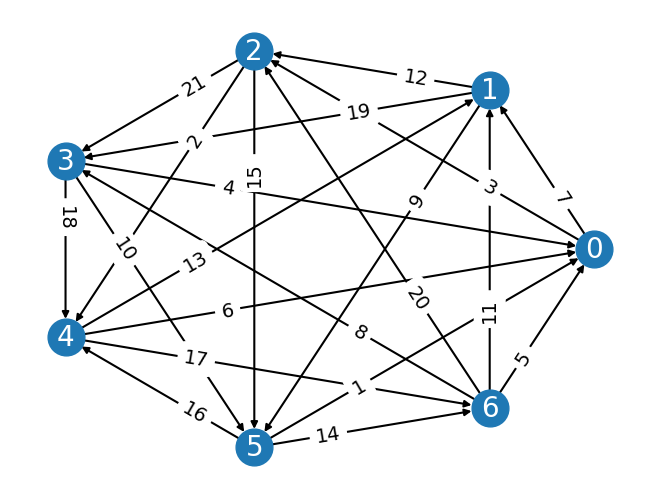

Time: 24.247191999995266
Split Cycle Winners: [0, 5, 6]
Stable Voting Winner: [5]
Simple Stable Voting Winner: [1]
453
111000101101011101101

[(0, 1), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (1, 5), (6, 1), (2, 3), (4, 2), (2, 5), (2, 6), (3, 4), (5, 3), (3, 6), (4, 5), (6, 4), (5, 6)]
checking critical edge 1: (0, 1)

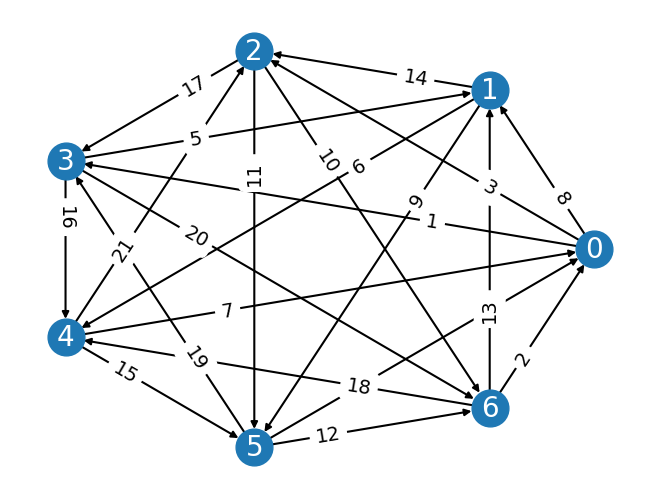

Time: 30.875341999999364
Split Cycle Winners: [0, 5]
Stable Voting Winner: [5]
Simple Stable Voting Winner: [1]
454
111000101101101011101

[(0, 1), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (3, 1), (1, 4), (1, 5), (6, 1), (2, 3), (2, 4), (5, 2), (2, 6), (4, 3), (3, 5), (3, 6), (4, 5), (6, 4), (5, 6)]
No counterexamples of size 7 for bitstring 111000101101101011101

455
111000110011011111000
[(0, 1), (0, 2), (0, 3), (4, 0), (5, 0), (6, 0), (1, 2), (1, 3), (4, 1), (5, 1), (1, 6), (2, 3), (4, 2), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (5, 4), (6, 4), (6, 5)]
checking critical edge 1: (0, 1)

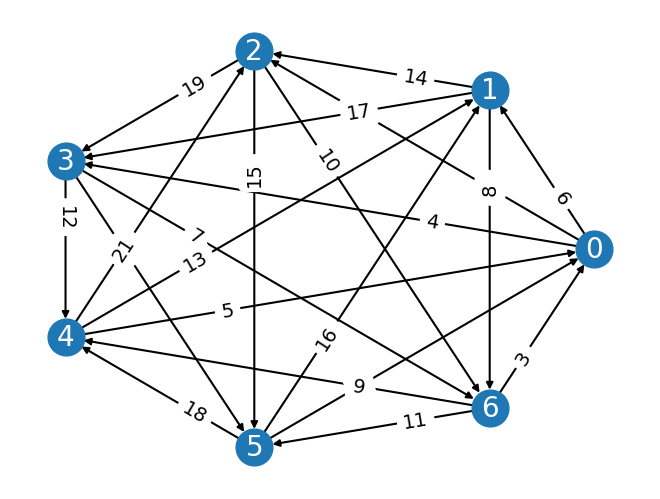

Time: 29.621877000005043
Split Cycle Winners: [0, 4, 6]
Stable Voting Winner: [6]
Simple Stable Voting Winner: [1]
456


In [8]:
f_iso = open('noniso7.txt', 'r')

f_log = open('prev_run_log.txt', 'w')

numchecked = 0
for bitstring in f_iso: # bitstr = iso class of tournaments
    foundp = call_solver_on_tournament(bitstring)

    f_log.write(str(foundp) + "---" + bitstring)
    
    numchecked += 1
    print(numchecked)
    
    
